In [1]:
using Pkg

In [2]:
Pkg.activate("..")

using Distributions
using CairoMakie
using LinearAlgebra
# using XML
using MiCRM_stability
using KrylovKit
using Graphs
using GraphMakie


  Activating project at `~/Projects/Working/HIFMB/MiCRM_stability`


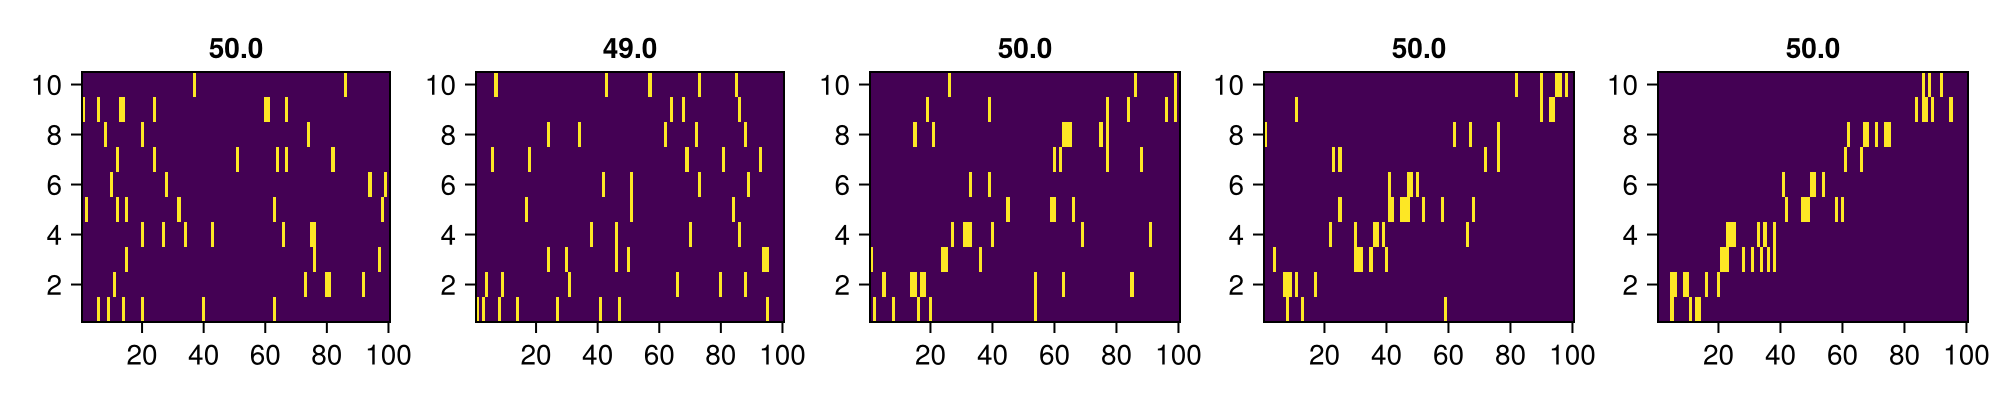

In [90]:
f = Figure(size = (1000,200))
for i = 1:5
    x = MiCRM_stability.modular_matrix(100,10, 5, (i-1) / 4, 50)
    
    ax = Axis(f[1,i], title = string(sum(x)))
    heatmap!(ax,  x)
end
f

In [4]:
function modular_community(N,M,Ku,Kd,Qu,Qd,Lu,Ld)
    U = MiCRM_stability.modular_matrix(N,M,Ku,Qu,Lu)
    [U[i,:] .= U[i,:] ./ sum(U[i,:]) for i = 1:N]
    U[isnan.(U)] .= 0.0
    
    D = MiCRM_stability.modular_matrix(M,M,Kd,Qd,Ld)
    [D[i,:] .= D[i,:] ./ sum(D[i,:]) for i = 1:M]
    D[isnan.(D)] .= 0.0

    return(MiCRM_stability.Community(N,M,U,D))
end

modular_community (generic function with 1 method)

In [5]:
modular_community(100,100,5,5,0.5,0.5,500,500)

MiCRM_stability.Community(100, 100, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.3333333333333333 0.0 … 0.0 0.3333333333333333; 0.0 0.0 … 0.1111111111111111 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.1111111111111111 … 0.0 0.0])

In [6]:
# functions for simulations
function get_exponential_parameters(N::Int64,M::Int64,σ::Float64)
    gx = rand(Uniform(0,1),N) 
    gs = rand(Uniform(0,2), N)
    mx = gx
    
    fy = rand(Uniform(1,2),N,M) 
    λy = zeros(N)

    iy = zeros(M)
    oy = rand(Uniform(0.5,1.5), M)

    return MiCRM_stability.exponential_params(gx,gs,mx,fy,λy,iy,oy)
end


function modular_community(N, M, f, Qu, Qd, L)
    c = MiCRM_stability.modular_community(N,M,5,5,Qu,Qd, L, L)

    Λ = rand(Uniform(0.1,0.8)) .+ rand(Uniform(-0.1,0.1),N) 
    G = rand(Uniform(0.1,1.0)) .+ rand(Uniform(-0.1,0.1),N) 
    α = rand(Uniform(0.1,1.0)) .+ rand(Uniform(-0.1,0.1),M) 
    β = rand(Uniform(0.1,1.0)) .+ rand(Uniform(-0.1,0.1),M) 
    C_pert = rand(Uniform(0.1,1.0)) .+ rand(Uniform(-0.1,0.1),M) 
    
    s = MiCRM_stability.get_structural_params(c.N, c.M, c.U,c.D, Λ, G, α, β, C_pert)
    e = f(N,M, 0.1)
    
    p = MiCRM_stability.Parameters(N,M,s,e)

    return(p)
end


function get_real(x::T) where T <: AbstractFloat
    x
end

get_real(x::Complex) = x.re

get_real (generic function with 2 methods)

In [76]:
N = M = 25

res = zeros(25,25,100)
res_norm = similar(res)

Threads.@threads for p = 1:25
    for q = 1:25
        for r = 1:100
            param = modular_community(N, M, get_exponential_parameters, p/25, q/25, N * 5)
            J = zeros(N + M, N + M)
            MiCRM_stability.jacobian!(param, J)

            e = eigen(J)
            
            res[p,q,r] = get_real(e.values[end])
            v_con = normalize(e.vectors[1:N,end])
            res_norm[p,q,r] = norm(v_con, 4)
        end
    end
end

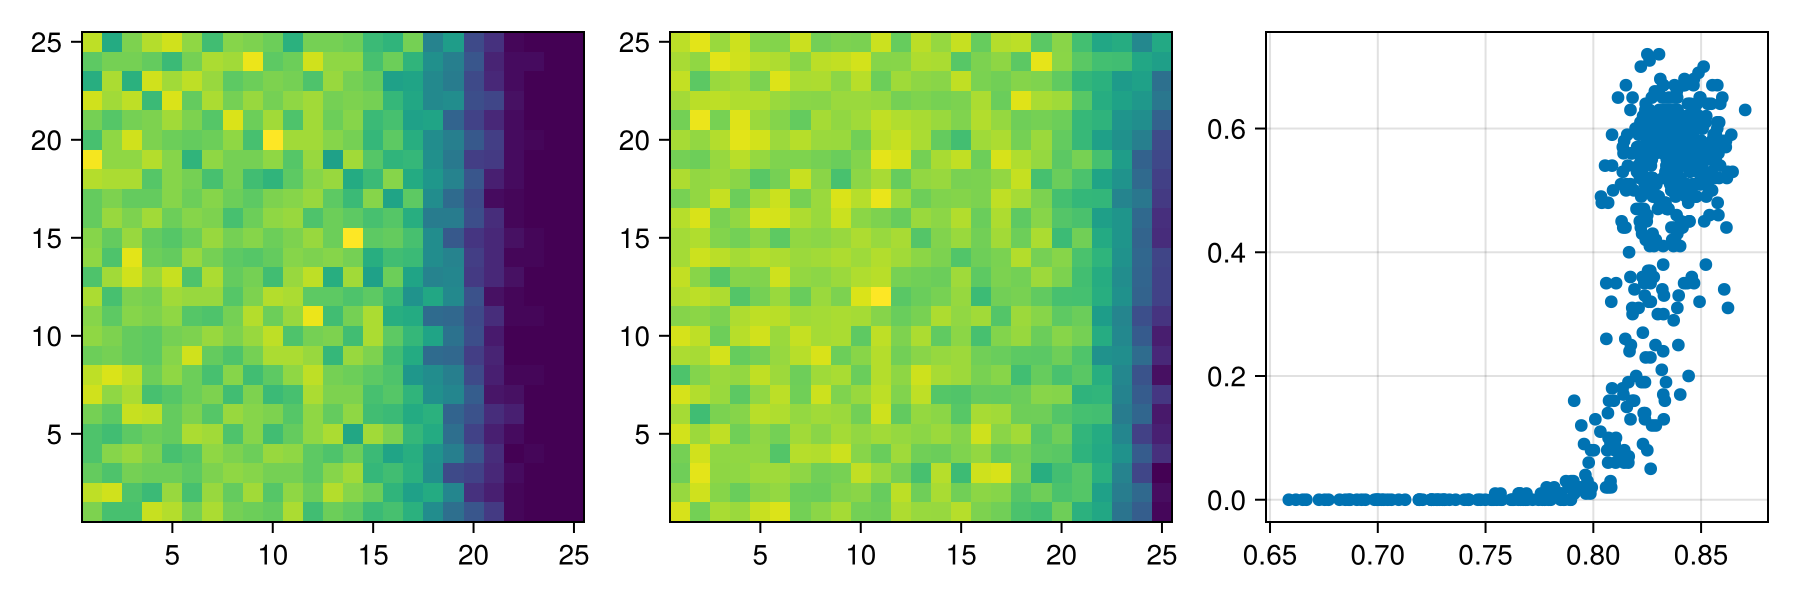

In [78]:
f = Figure(size = (900,300))
ax = Axis(f[1,1])
heatmap!(ax, mean(res .< 0, dims = 3)[:,:,1])
ax = Axis(f[1,2])
heatmap!(ax, mean(res_norm, dims = 3)[:,:,1])
ax=Axis(f[1,3])
plot!(ax, mean(res_norm, dims = 3)[:], mean(res .< 0, dims = 3)[:],)
f

0.684588567434418

In [120]:
N = 20
M = 20

function block_full_eigenvalue(N,M)
    p = random_community(N, M, get_exponential_parameters, 1.0)
    J = zeros(N + M, N + M)
    MiCRM_stability.jacobian!(p, J)
    
    #split jaccobian 
    Jcc = J[1:N,1:N]
    Jcr = J[1:N,N+1:end]
    Jrc = J[N+1:end,1:N]
    Jrr = J[N+1:end,N+1:end]

    M = Jcr * inv(Jrr) * Jrc
    
    λ = eigen(J).values[end] |> get_real
    
    λcc = eigen(M).values[end] |> get_real
    # λcr = eigen(Jcr).values[end]
    # λrc = eigen(Jrc).values[end]
    λrr = eigen(Jcc).values[end] |> get_real
    
    return([λ,  λcc, λrr])
end

block_full_eigenvalue (generic function with 1 method)

In [121]:
res = Matrix{Any}(undef, 100, 100)

Threads.@threads for i = 1:100
    for j = 1:100
        res[i,j] = block_full_eigenvalue(20, 20 + i)
    end
end


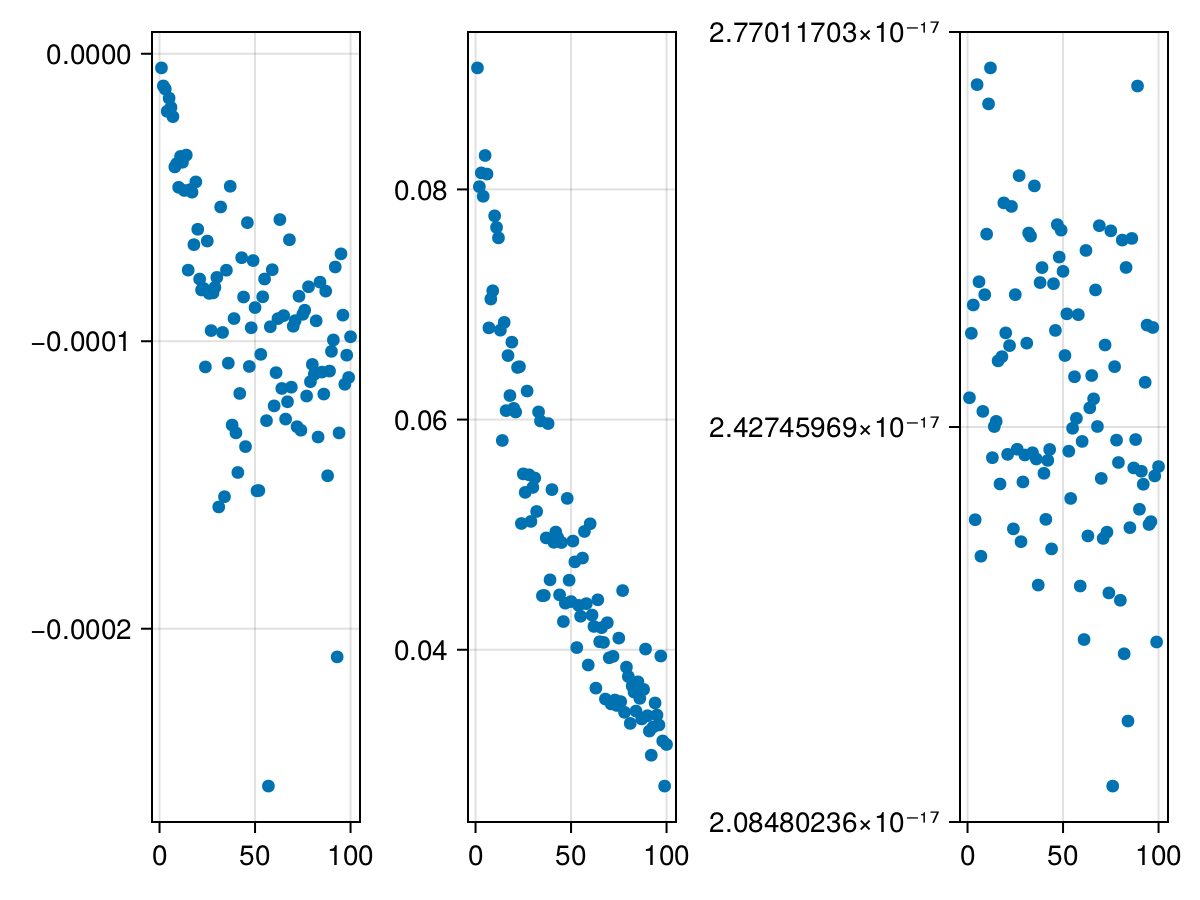

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194


In [122]:
f = Figure()
for i = 1:3
    ax = Axis(f[1,i])
    plot!(ax, mean([x[i] for x = res], dims = 2)[:])
end
f

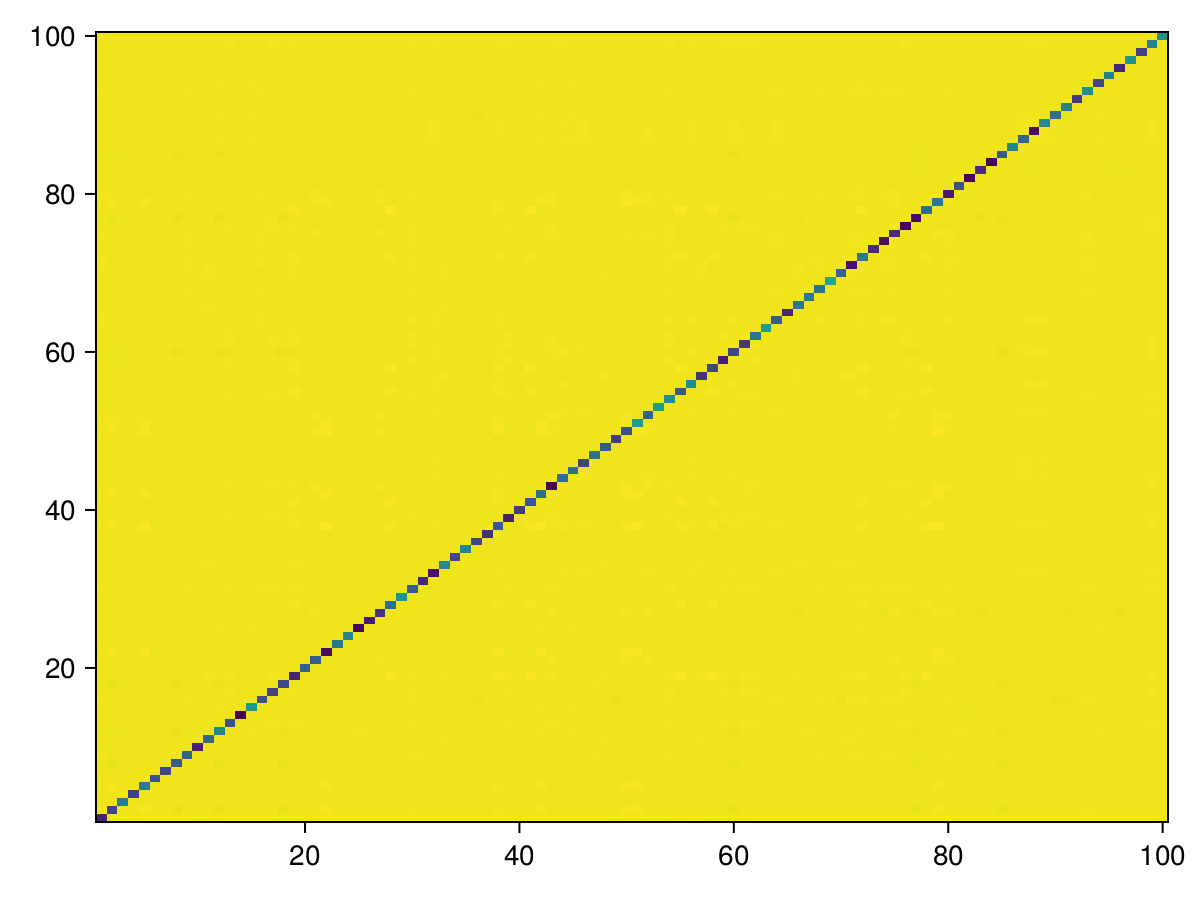

In [90]:
N = 20
M = 100
p = random_community(N, M, get_exponential_parameters, 1.0)
    J = zeros(N + M, N + M)
    MiCRM_stability.jacobian!(p, J)
    
    #split jaccobian 
    Jcc = J[1:N,1:N]
    Jcr = J[1:N,N+1:end]
    Jrc = J[N+1:end,1:N]
    Jrr = J[N+1:end,N+1:end]

Jrr |> heatmap

In [382]:
function get_exponential_parameters(N::Int64,M::Int64,σ::Float64)
    gx = rand(Uniform(0.8,1.2), N)
    gs = ones(N) 
    mx = rand(Uniform(0.8,1.2), N)
    
    fy = ones(N,M)
    λy = zeros(N)

    iy = ones(M)
    oy = zeros(N)

    return MiCRM_stability.exponential_params(gx,gs,mx,fy,λy,iy,oy)
end

function random_community(N,M,f,C,Λp)
    c = MiCRM_stability.random_community(N,M,C,C)

    while any(sum(c.U, dims = 2) .== 0)
        c = MiCRM_stability.random_community(N,M, C,C)
    end
        # #evey consumer has a link
    # for i = 1:N
    #     if sum(U[i,:]) == 0
    #         U[i, rand(1:M)]
    #     end
    # end
    Λ = fill(Λp, N)
    I = rand(Uniform(0.2,1.0), M)
    
    s = MiCRM_stability.get_structural_params(c.N, c.M, c.U, c.D, Λ, 10.0)
    e = f(N,M, 0.1)
    
    p = MiCRM_stability.Parameters(N,M,s,e)

    return(p,c,e)
end

random_community (generic function with 2 methods)

In [385]:
N,M = 100,100
p = random_community(N,M,get_exponential_parameters,0.8, 0.9)
#jaccobian
J = zeros(N+M, N+M)
MiCRM_stability.jacobian!(p[1], J)
eigen(J).values[end] |> println

Jcc = J[1:N,1:N]
Jcr = J[1:N,N+1:end]
Jrc = J[N+1:end,1:N]
Jrr = J[N+1:end,N+1:end]

Jeff = Jcc - Jcr*inv(Jrr)*Jrc

eigen(Jeff).values[end] |> println

Jrr

0.04823575619923364 + 0.022209820193266037im
0.03110314710781173


100×100 Matrix{Float64}:
 -0.718049     0.00949796   0.00934613  …   0.0          0.0
  0.0101506   -0.660634     0.00948312      0.0102398    0.0
  0.0104118    0.00988516  -0.803187        0.0105033    0.0
  0.0101612    0.00964718   0.00949296      0.0102504    0.0
  0.0113037    0.0107319    0.0105604       0.011403     0.0104378
  0.0          0.00987857   0.00972066  …   0.0104963    0.0
  0.0106244    0.010087     0.00992578      0.0107178    0.00981056
  0.0          0.0098491    0.00969166      0.010465     0.00957917
  0.0098044    0.00930846   0.00915966      0.00989052   0.00905334
  0.0103579    0.00983398   0.00967678      0.0104489    0.00956446
  0.0102502    0.0          0.00957614  …   0.0103402    0.00946499
  0.0100453    0.00953722   0.0             0.0101336    0.00927583
  0.0          0.009941     0.00978209      0.0105626    0.0
  ⋮                                     ⋱               
  0.010698     0.0101569    0.00999453      0.010792     0.00987852
  0.01093

In [380]:
p[1].e.iy

100-element Vector{Float64}:
 100.0
 100.0
 100.0
 100.0
 100.0
 100.0
 100.0
 100.0
 100.0
 100.0
 100.0
 100.0
 100.0
   ⋮
 100.0
 100.0
 100.0
 100.0
 100.0
 100.0
 100.0
 100.0
 100.0
 100.0
 100.0
 100.0

In [19]:
function size_eig(N,M,C)
    p,c,e = random_community(N,M, get_exponential_parameters,C)

    p.e.gx .= rand(Uniform(0.8,1.2), N)
    p.e.mx .= p.e.gx .+ rand(Normal(0.0, 1e-2))
    p.e.λg .= 1.0
    
    #jaccobian
    J = zeros(N+M, N+M)
    MiCRM_stability.jacobian!(p, J)

    return(J, p, c)
end



size_eig (generic function with 1 method)

In [20]:
J,p,c = size_eig(100, 100, 0.9)

eigen(J)

LoadError: DimensionMismatch: A has dimensions (100,1) but B has dimensions (100,100)

In [92]:
χ = p.s.χ
D = p.s.D

N = 100
M = 100

σ = 0.2 .+ rand(M) .* 0.2
ρ = fill(0.5, M)

Utot = (1 .- σ) ./ σ
G = Utot' * inv(χ')


# #calculate Ktot
# Ktot = (1 .- ρ) .* (Utot .+ 1)
# Λtmp = Ktot' * inv((χ * D)')
# Λ = Λtmp ./ G

1×100 adjoint(::Vector{Float64}) with eltype Float64:
 -23.7502  2.71136  2.24467  -14.7883  30.751  …  64.7371  23.6855  -64.7601

In [80]:
1 ./ (Utot .+ 1)

100-element Vector{Float64}:
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 ⋮
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01

In [11]:
using Random
using Profile
Random.seed!(1)

eigen(size_eig(100,100)[1]).values[end]

# Profile.clear()
# Profile.@profile J, p, c = size_eig(1000,1000);
# Profile.print(format = :flat)

# A = J[1:N, 1:N]
# B = J[1:N, N+1: end]
# C = J[N+1:end, 1:N]
# D = J[N+1:end, N +1:end]

# S =  -B* inv(D) * C

# eigen(J).values[end] |> println
# eigen(D).values[end] |> println
# eigen(S).values[end] |> println


LoadError: MethodError: no method matching size_eig(::Int64, ::Int64)

[0mClosest candidates are:
[0m  size_eig(::Any, ::Any, [91m::Any[39m)
[0m[90m   @[39m [35mMain[39m [90m[4mIn[9]:1[24m[39m


In [12]:
Random.seed!(1)
@time J, p, c = size_eig(1000,1000)
Profile.clear()
Profile.@profile MiCRM_stability.jacobian!(p, J)
Profile.print(format = :flat)

LoadError: MethodError: no method matching size_eig(::Int64, ::Int64)

[0mClosest candidates are:
[0m  size_eig(::Any, ::Any, [91m::Any[39m)
[0m[90m   @[39m [35mMain[39m [90m[4mIn[9]:1[24m[39m


In [43]:
@time J, p, c = size_eig(1000,1000)
@time MiCRM_stability.jacobian!(p, J)
@time eigen(J).values[end]

  0.081576 seconds (10.09 k allocations: 200.220 MiB, 32.01% gc time)
  0.496751 seconds
  0.594599 seconds (10.28 k allocations: 230.767 MiB, 4.39% gc time)
  0.487457 seconds
  2.549156 seconds (24 allocations: 124.208 MiB, 1.49% gc time)


0.04103413468091465 + 0.0im

In [44]:
@time MiCRM_stability.jacobian_O!(p, J)
@time eigen(J).values[end]

LoadError: type structural_params has no field ϕ_norm

In [135]:
Profile.clear()
@profile MiCRM_stability.jacobian!(p, J)
Profile.print()

Overhead ╎ [+additional indent] Count File:Line; Function
    ╎8525 @Base/task.jl:675; task_done_hook(t::Task)
    ╎ 8525 @Base/task.jl:994; wait()
8524╎  8525 @Base/task.jl:985; poptask(W::Base.IntrusiveLinkedListSynchronized{…
    ╎275  …ulia/src/eventloop.jl:38; (::IJulia.var"#15#18")()
    ╎ 275  …Julia/src/eventloop.jl:8; eventloop(socket::ZMQ.Socket)
    ╎  275  @Base/essentials.jl:889; invokelatest
    ╎   275  @Base/essentials.jl:892; #invokelatest#2
    ╎    275  …c/execute_request.jl:67; execute_request(socket::ZMQ.Socket, msg…
    ╎     275  …c/SoftGlobalScope.jl:65; softscope_include_string(m::Module, co…
    ╎    ╎ 275  @Base/loading.jl:2076; include_string(mapexpr::typeof(REPL.soft…
    ╎    ╎  275  @Base/boot.jl:385; eval
    ╎    ╎   1    …ity/src/jacobian.jl:13; jacobian!(p::MiCRM_stability.Paramet…
    ╎    ╎    1    @Base/broadcast.jl:911; materialize!
    ╎    ╎     1    @Base/broadcast.jl:914; materialize!
    ╎    ╎    ╎ 1    @Base/broadcast.jl:964; copyto!
    ╎ 

In [128]:
using BenchmarkTools

@benchmark MiCRM_stability.jacobian!(p, J)

BenchmarkTools.Trial: 3 samples with 1 evaluation per sample.
 Range (min … max):  1.710 s …   1.767 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.723 s              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.733 s ± 29.944 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █           █                                           █  
  █▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.71 s         Histogram: frequency by time        1.77 s <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [129]:
@benchmark MiCRM_stability.jacobian_O!(p, J)

BenchmarkTools.Trial: 1 sample with 1 evaluation per sample.
 Single result which took 6.033 s (0.00% GC) to evaluate,
 with a memory estimate of 0 bytes, over 0 allocations.

# N=100
M=50

function S_eig(N,M)
    J, mx = size_eig(N,M)
    
    A = J[1:N, 1:N]
    B = J[1:N, N+1: end]
    C = J[N+1:end, 1:N]
    D = J[N+1:end, N +1:end]
    
    S = A - B* inv(D) * C
    
    eigen(S).values[end]
end

In [1657]:
real(S_eig(1,200)) 

-0.00512240299787006

In [43]:
using LinearMaps

function get_exponential_parameters(N::Int64,M::Int64,σ::Float64, K::Float64)
    gx = rand(Uniform(0.8,1.2), N)
    gs = rand(Uniform(0.5,2.0), N) 
    mx = gx .+ K #rand(Uniform(-2σ*K, (1-K)*2σ), N)
    
    fy = rand(Uniform(1,2), N, M)
    λy = zeros(N,M)

    iy = zeros(M)
    oy = rand(Uniform(1.0,1.5),M) 

    return MiCRM_stability.exponential_params(gx,gs,mx,fy,λy,iy,oy)
end

function random_community(N,M,f, K)
    @time c = MiCRM_stability.random_community(N,M, rand(), rand())

    println(any(sum(c.U, dims = 2) .== 0))
    while any(sum(c.U, dims = 2) .== 0)
        c = MiCRM_stability.random_community(N,M, rand(), rand())
    end
        # #evey consumer has a link
    # for i = 1:N
    #     if sum(U[i,:]) == 0
    #         U[i, rand(1:M)]
    #     end
    # end
    Λ = rand(N) * 0.25
    I = rand(M) 
    @time s = MiCRM_stability.get_structural_params(c.N, c.M, c.U,c.D, Λ, I)
    e = f(N,M, 0.1, K)
    
    @time p = MiCRM_stability.Parameters(N,M,s,e)

    return(p)
end

function get_real(x::T) where T <: AbstractFloat
    x
end

get_real(x::Complex) = x.re

function inner_kry(i, j, r, k, N, M, K)
    #param
    @time p = random_community(N, M, get_exponential_parameters, K)
    #jaccobian
    J = zeros(N + M, N + M)
    @time MiCRM_stability.jacobian!(p, J)
    x=0.0
    try 
    @time x = get_real(eigsolve(J, 1, (:LR))[1][1])  
    catch
        x = 0.0
    end
    return(x)
end

function inner_lm(i, j, r, k, N, M, K)
    #param
    @time p = random_community(N, M, get_exponential_parameters, K)
    #jaccobian
    N_total = p.N + p.M
    Jv = (y, v) -> MiCRM_stability.jacobian_product!(y, v, p)
    Jmap = LinearMap(Float64, Jv, N_total; ismutating=true)
    x=0.0
    @time eigval, eigvec = eigsolve(Jmap, randn(N_total), 1, :LR)
    λ
end

inner_lm (generic function with 1 method)

In [50]:
using Profile
N = 1000
M = 1000

c = MiCRM_stability.random_community(N,M, rand(), rand())
Λ = rand(N) * 0.25
I = rand(M)
@time s = MiCRM_stability.get_structural_params(c.N, c.M, c.U,c.D, Λ, I)


# @time p = random_community(N,M, get_exponential_parameters, 0.1)

# begin
#     #jaccobian
#     J = zeros(N + M, N + M)
#     @time MiCRM_stability.jacobian!(p, J)
#     @time x = eigsolve(J, 1, (:LR))[1][1]  
# end

  0.073321 seconds (6.04 k allocations: 100.046 MiB, 9.58% gc time)


MiCRM_stability.structural_params([0.4192901375807976, 0.4149003757277936, 0.39173102474356364, 0.27976982361593267, 0.4553196143709102, 0.28010817556241563, 0.2674566813170443, 0.34648738082139924, 0.4422802127682005, 0.4426292362952453  …  0.4310293634252551, 0.3991545409946858, 0.3312619164122212, 0.41716585035088816, 0.4529073487887477, 0.31548502171701137, 0.440753421107675, 0.31339117998980703, 0.3228638773828615, 0.44847417889579944], [0.7988337562199452, 0.8372813055317463, 0.9032217629235101, 0.7253512729455323, 0.8998295359837624, 0.7623721551818028, 0.7118519817956863, 0.8102164709890667, 0.8865524095427941, 0.8036213313382082  …  0.8325986927540567, 0.7936747609298309, 0.8819999727816187, 0.7515607975203858, 0.7280850031632246, 0.7198509882783123, 0.7364970392500516, 0.7553590187748538, 0.8585795414890789, 0.7594024801086928], [0.18708513612906832, 0.024398561973862254, 0.1874373521587576, 0.23929184444567458, 0.0534563414662374, 0.07111452726102471, 0.08225579196169178, 0.

In [235]:
((c.U * c.D) .> 0) |> sum

1000000

In [200]:
begin
    #jaccobian
    N_total = p.N + p.M
    Jv = (y, v) -> MiCRM_stability.jacobian_product!(y, v, p)
    Jv(zeros(p.N),zeros(p.M))
    Jmap = LinearMap(Jv, N_total, N_total; ismutating=true,issymmetric = false)
    @time eigval, eigvec = eigsolve(Jmap, randn(N_total), 1, :LR)
end

eigval

  0.586219 seconds (630.50 k allocations: 42.899 MiB, 2.16% gc time, 68.45% compilation time)


1-element Vector{ComplexF64}:
 -0.049080201489297016 + 0.0im

In [236]:
eigen(J).values[end]

┌ Error: Failed to revise /home/tom/.julia/dev/MiCRM_stability/src/types.jl
│   exception =
│    invalid redefinition of constant MiCRM_stability.structural_params
│    Stacktrace:
│     [1] top-level scope
│       @ ~/.julia/dev/MiCRM_stability/src/types.jl:1
│    Revise evaluation error at /home/tom/.julia/dev/MiCRM_stability/src/types.jl:1
│    
└ @ Revise ~/.julia/packages/Revise/bAgL0/src/packagedef.jl:722
┌ Warning: The running code does not match the saved version for the following files:
│ 
│   /home/tom/.julia/dev/MiCRM_stability/src/types.jl
│ 
│ If the error was due to evaluation order, it can sometimes be resolved by calling `Revise.retry()`.
│ Use Revise.errors() to report errors again. Only the first error in each file is shown.
│ Your prompt color may be yellow until the errors are resolved.
└ @ Revise ~/.julia/packages/Revise/bAgL0/src/packagedef.jl:832


0.0 + 0.0im

In [169]:
inner_lm(1,1,1,1, 100,100, 0.0)

  0.005630 seconds (1.29 k allocations: 9.996 MiB)


LoadError: MethodError: no method matching Float64(::Vector{Float64}, ::Vector{Float64})

In [126]:
J

200×200 Matrix{Float64}:
 -0.102973      0.0           0.0          …   0.0121343     0.00147274
  0.0          -0.0265583     0.0              0.0           0.0
  0.0           0.0          -0.127342         0.0           0.0
  0.0           0.0           0.0              0.0           0.0
  0.0           0.0           0.0              0.0           0.0
  0.0           0.0           0.0          …   0.0           0.0134892
  0.0           0.0           0.0              0.0           0.0
  0.0           0.0           0.0              0.0           0.0
  0.0           0.0           0.0              0.00380533    0.0
  0.0           0.0           0.0              0.0414052     0.0336524
  0.0           0.0           0.0          …   0.0           0.0
  0.0           0.0           0.0              0.0           0.0
  0.0           0.0           0.0              0.0           0.0
  ⋮                                        ⋱                
  0.000168718   0.000396747  -0.0199445        0.0

In [57]:
function test()
    for i = 1:100
        inner(1,1,1,1, 100,100, 0.0)
    end
end

test()
@time test()

using Profile
Profile.clear()
Profile.@profile test()
Profile.print(format = :flat, sortedby = :count)

  5.518145 seconds (3.03 M allocations: 2.223 GiB, 1.42% gc time)
 Count  Overhead File                    Line Function
 =====  ======== ====                    ==== ========
     1         1 @Base/partr.jl           158 multiq_deletemin()
     1         0 …ity/src/parameters.jl    22 get_structural_params(N::Int64, M…
     1         0 @Base/broadcast.jl       636 getindex
     1         0 @Base/broadcast.jl       681 _broadcast_getindex
     1         0 @Base/broadcast.jl       705 _getindex
     1         0 @Base/broadcast.jl       675 _broadcast_getindex
     1         0 @Base/task.jl            478 macro expansion
     1         0 @Base/channels.jl         58 Channel
     1         0 @Base/channels.jl         56 Channel
     1         0 @Base/channels.jl         47 Channel
     1         1 @Base/lock.jl             49 ReentrantLock
     1         0 …vKit/src/KrylovKit.jl    77 splitrange
     1         0 @Base/range.jl           794 length(r::StepRange{Int64, Int64})
     1       

In [1236]:
function getvar(N,M) 
    J, mx = size_eig(N,M)
    A = J[1:N, 1:N]
    B = J[1:N, N+1: end]
    C = J[N+1:end, 1:N]
    D = J[N+1:end, N +1:end]

    S = -B* inv(D) * C
    return(mean(S),var(S),norm(S))
end

x = [getvar.(50,M) for M = 10:10:100, r = 1:20]

10×20 Matrix{Tuple{Float64, Float64, Float64}}:
 (-0.00129335, 1.43052e-6, 0.0880726)  …  (-0.00347849, 1.69701e-5, 0.269551)
 (-0.00842381, 3.30808e-5, 0.509971)      (-0.000386374, 1.31523e-7, 0.0264932)
 (-0.0111282, 0.000220489, 0.927684)      (-0.000929338, 5.25293e-7, 0.0589227)
 (-0.0121859, 0.000138718, 0.847287)      (-0.00361403, 1.03544e-5, 0.241927)
 (-0.00176408, 7.9614e-6, 0.166359)       (-0.00457045, 3.40395e-6, 0.246432)
 (-0.00788566, 6.82819e-5, 0.571048)   …  (-0.00203485, 1.93323e-6, 0.123218)
 (-0.00419421, 1.23962e-5, 0.273782)      (-0.00167859, 8.02826e-6, 0.164641)
 (-0.00176875, 1.58583e-6, 0.108555)      (-0.00152879, 1.19235e-5, 0.188785)
 (-0.00815507, 5.09101e-5, 0.541745)      (-0.00351687, 6.55659e-6, 0.217499)
 (-0.00413088, 3.80327e-6, 0.228396)      (-0.00199821, 5.13142e-6, 0.151015)

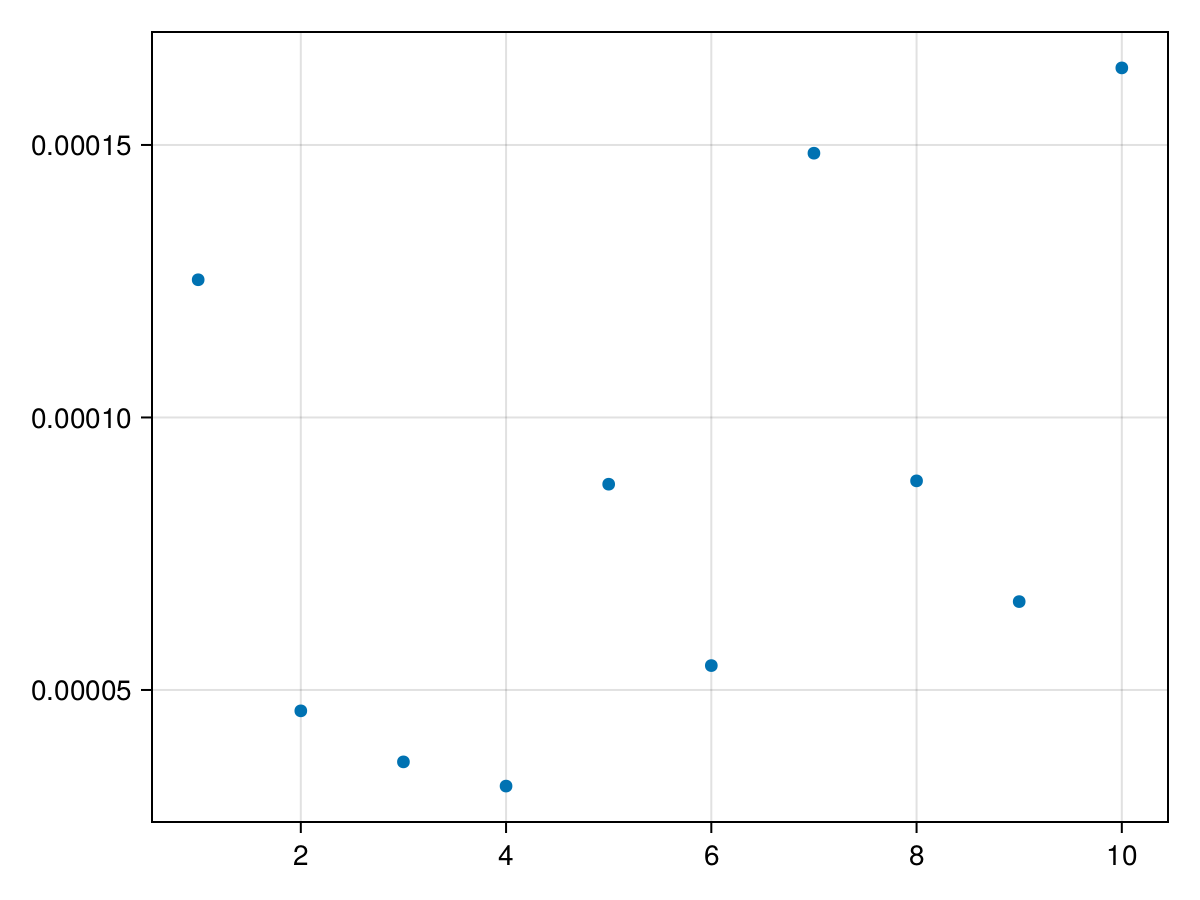

In [1231]:
mean([x[2] for x = x], dims = 2)[:] |> plot

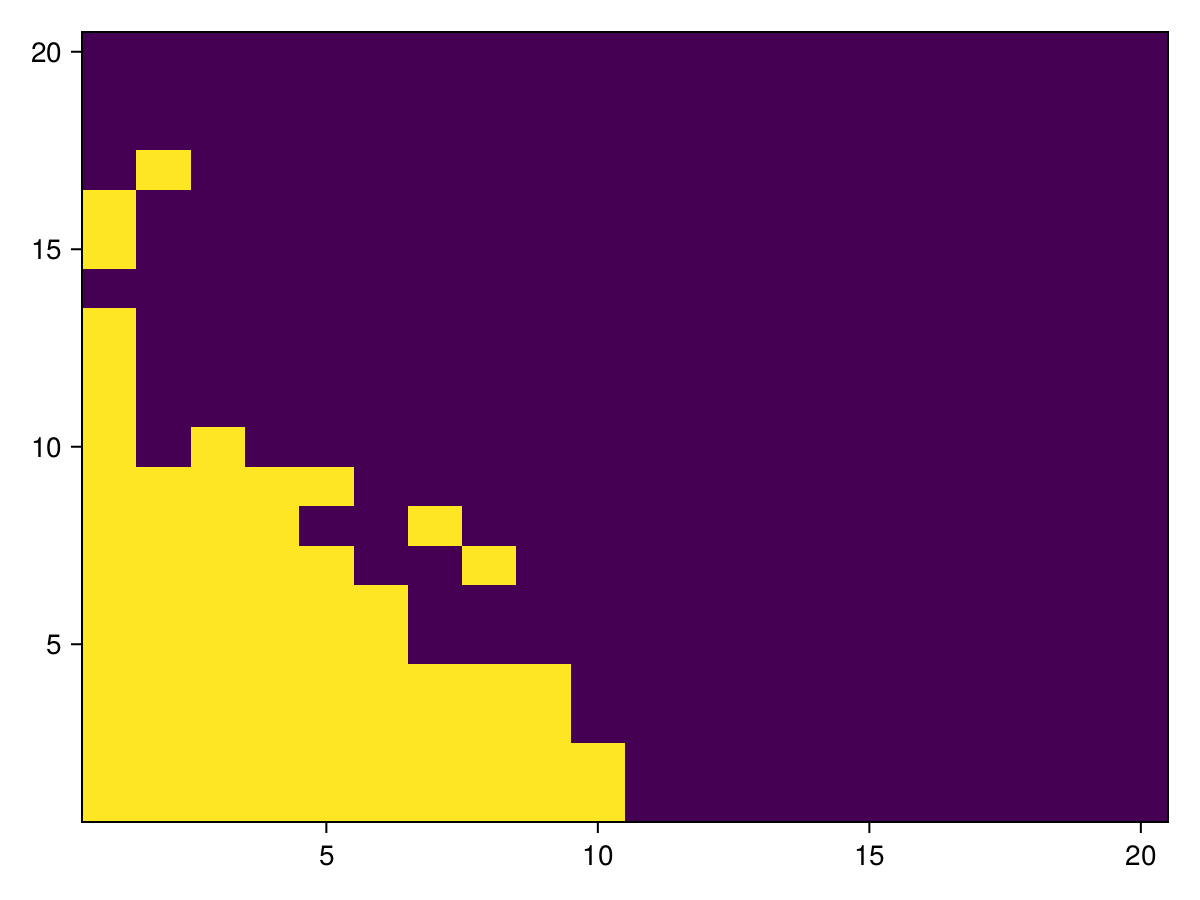

In [914]:
N = 50
M = 50
c = MiCRM_stability.random_community(N,M, 0.3, 0.3)

while any(sum(c.U, dims = 2) .== 0)
    c = MiCRM_stability.random_community(N,M, rand(), rand())
end

Λ = ones(N) * 0.25
Inp = ones(M) 
s = MiCRM_stability.get_structural_params(c.N, c.M, c.U,c.D, Λ, Inp)
e = get_exponential_parameters(N,M, 0.1)
p = MiCRM_stability.Parameters(N,M,s,e);

#jaccobian
J = zeros(N+M, N+M)

p.e.mx .= 1.0

function lreal(μ,σ)
    p.e.gx .= rand(Normal(μ, σ), N)
    

    MiCRM_stability.jacobian!(p, J)
    real(eigen(J).values)[end]
end

μvec = range(0.9,1.1, length = 20)
σvec = range(0.0,0.1, length = 20)

r = [lreal(μ,σ) for μ = μvec, σ = σvec]

plot(r .< 0)

In [912]:
r

20×20 Matrix{Float64}:
 -0.0459023   -0.0459023   -0.0459023   …  -0.0459023   -0.0459023
 -0.0411151   -0.0411151   -0.0411151      -0.0411151   -0.0411151
 -0.0363241   -0.0363241   -0.0363241      -0.0363241   -0.0363241
 -0.0315288   -0.0315288   -0.0315288      -0.0315288   -0.0315288
 -0.0267283   -0.0267283   -0.0267283      -0.0267283   -0.0267283
 -0.0219213   -0.0219213   -0.0219213   …  -0.0219213   -0.0219213
 -0.017106    -0.017106    -0.017106       -0.017106    -0.017106
 -0.0122788   -0.0122788   -0.0122788      -0.0122788   -0.0122788
 -0.00743236  -0.00743236  -0.00743236     -0.00743236  -0.00743236
 -0.00253667  -0.00253667  -0.00253667     -0.00253667  -0.00253667
  0.00278388   0.00278388   0.00278388  …   0.00278388   0.00278388
  0.00854217   0.00854217   0.00854217      0.00854217   0.00854217
  0.0143809    0.0143809    0.0143809       0.0143809    0.0143809
  0.0203001    0.0203001    0.0203001       0.0203001    0.0203001
  0.0262646    0.0262646    0.026264

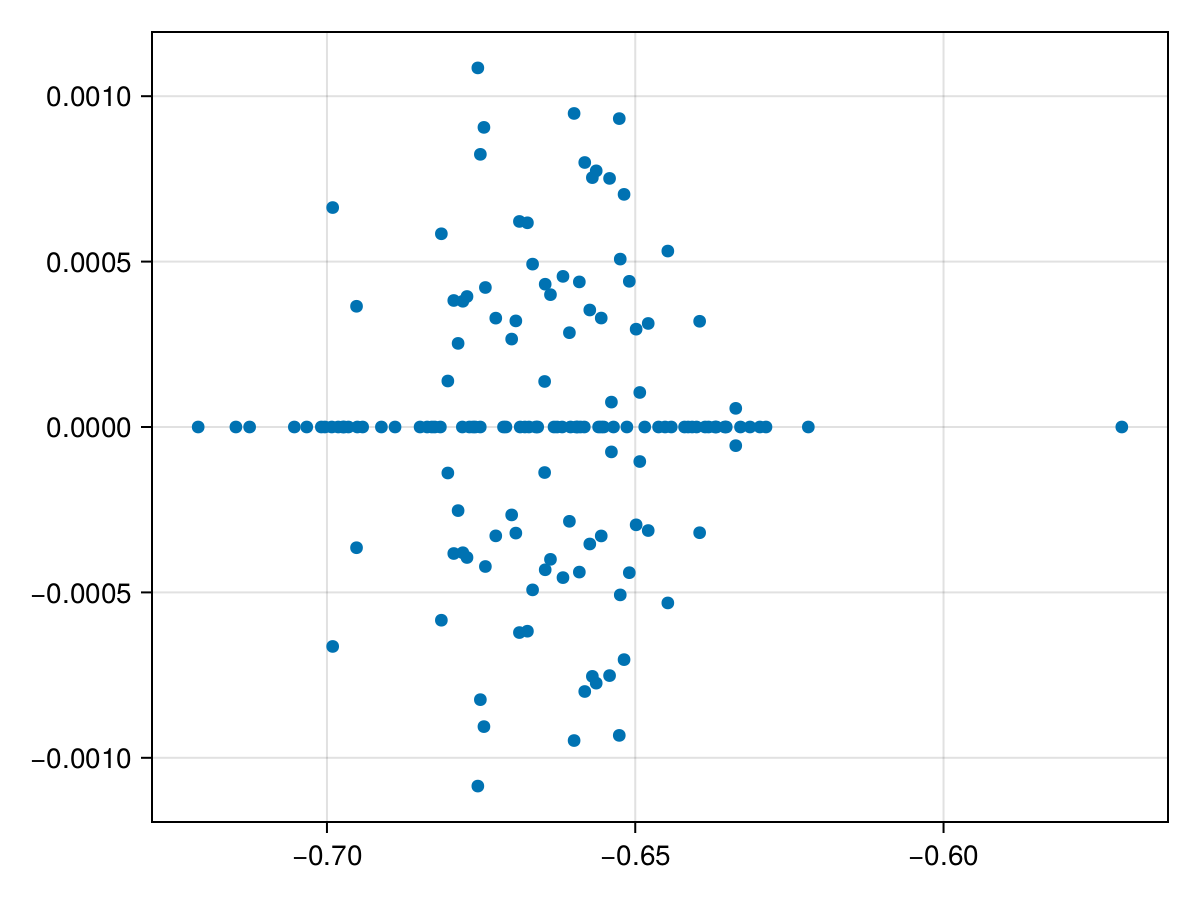

In [876]:
A = J[1:N, 1:N]
B = J[1:N, N+1: end]
C = J[N+1:end, 1:N]
D = J[N+1:end, N +1:end]



In [638]:
u_vec = zeros(2,100)

Threads.@threads for i = 1:100
    J = size_eig(100,i*2)
    
    A = J[1:N, 1:N]
    B = J[1:N, N+1: end]
    C = J[N+1:end, 1:N]
    D = J[N+1:end, N +1:end]

    u_vec[1,i] = var(B)
    u_vec[2,i] = var(C)
end
    

In [639]:
using Optim

In [1280]:
N = 100
M = 101

Cu = 0.3
Cd = 0.1

U = Float64.(rand(N,M) .< Cu)
U .= U .* rand(N,M)
#normalise consumer uptakes to 1
[U[i,:] .= U[i,:] ./ sum(U[i,:]) for i = 1:N]
U[isnan.(U)] .= 0.0

G = rand(LogNormal(rand(),rand()), N)
uptake = diagm(G) * U

U_mean = mean(uptake, dims = 1)[:] 

D =  Float64.(rand(M,M) .< Cd) 
D .= D .* rand(M,M)

α = 1.0
ϵ = 0.7
D = [ϵ * U_mean[a]^α + (1-ϵ) * D[a,b] for a = 1:M, b = 1:M]


plot(sum(D,dims=2)[:],sum(uptake,dims=1)[:])

D

101×101 Matrix{Float64}:
 0.0131481   0.0131481   0.0131481   …  0.0131481   0.0131481   0.0131481
 0.00995012  0.00995012  0.00995012     0.00995012  0.00995012  0.00995012
 0.014444    0.014444    0.014444       0.014444    0.119357    0.014444
 0.0100572   0.0100572   0.0100572      0.179944    0.276291    0.0100572
 0.0162051   0.0162051   0.0162051      0.0162051   0.0162051   0.0162051
 0.0108822   0.0108822   0.0108822   …  0.0108822   0.0108822   0.0108822
 0.0824006   0.013987    0.013987       0.013987    0.013987    0.013987
 0.243647    0.0118018   0.0118018      0.0118018   0.0118018   0.0118018
 0.0140495   0.0140495   0.0140495      0.0140495   0.0140495   0.0140495
 0.0167102   0.229788    0.0167102      0.0167102   0.0167102   0.0167102
 0.276284    0.0120792   0.0120792   …  0.0120792   0.0120792   0.0120792
 0.0084385   0.0084385   0.0084385      0.0084385   0.0084385   0.0084385
 0.0145217   0.0145217   0.0145217      0.0145217   0.0145217   0.0145217
 ⋮            

In [771]:
N=200
M=200
J = size_eig(N,M)
    
A = J[1:N, 1:N]
B = J[1:N, N+1: end]
C = J[N+1:end, 1:N]
D = J[N+1:end, N +1:end]

eigen(J).values[end] |> println
S = B * inv(D) * C
eigen(S).values[end] |> println
Dapp = diagm(diag(D))
eigen(A - (B * inv(Dapp) * C)).values[end] |> println

0.000858554306870474 + 0.0im
0.0004973342789526677 + 0.0im
0.0008591482724430819 + 0.0im


In [782]:
mean((B)) * mean((C)) * mean((B) .> 0) * mean((C) .> 0) * mean(1 ./ diag(D)) 

4.948111652045375e-10

-0.697629643020041

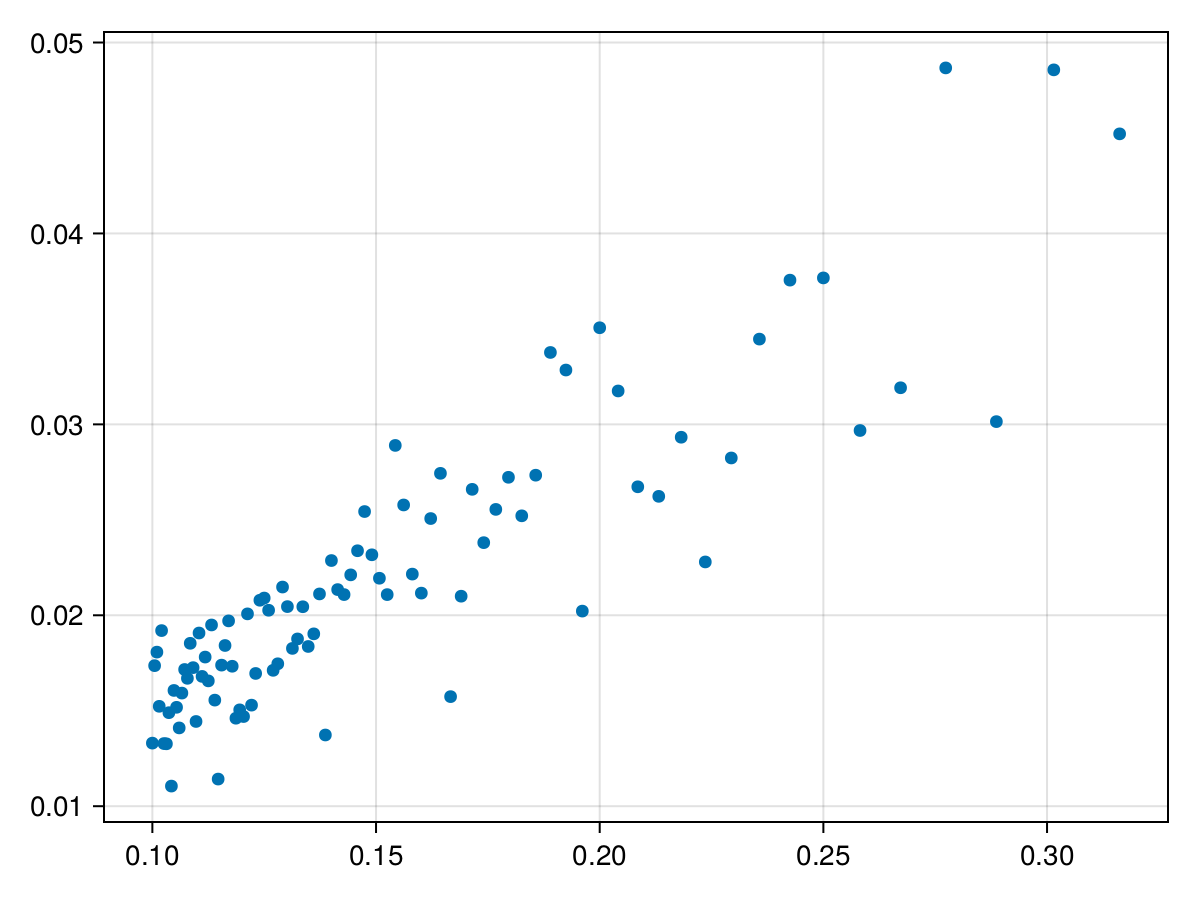

In [753]:
plot(1 ./ sqrt.(10:100), mean(x,dims = 1)[:] )

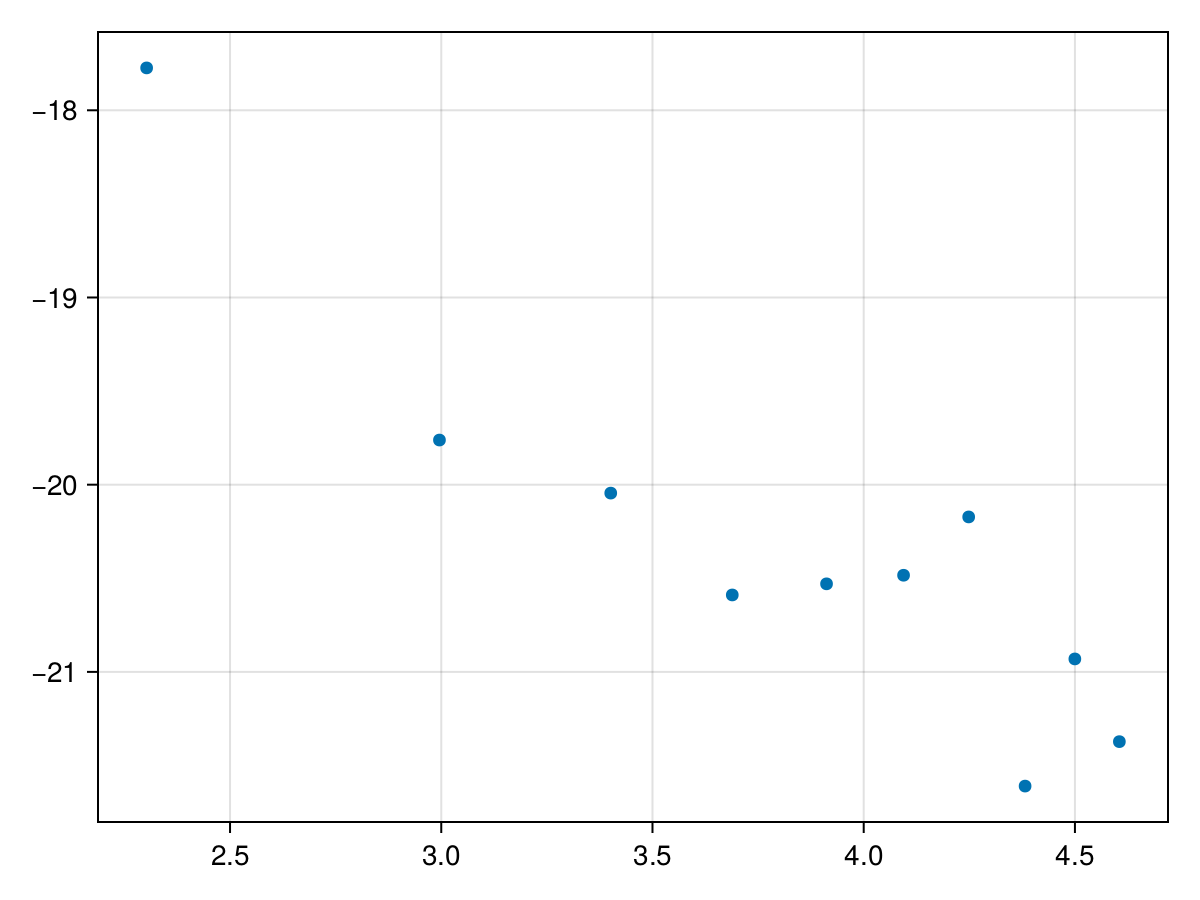

In [668]:
function off_S(N,M)
    J = size_eig(N,M)
        
    A = J[1:N, 1:N]
    B = J[1:N, N+1: end]
    C = J[N+1:end, 1:N]
    D = J[N+1:end, N +1:end]

    S = B * inv(D) * C

    return var(offdiag(S))
    
end

M_vec = 10:10:100
m = [off_S(50,M) for M = M_vec, r = 1:10]

plot(log.(M_vec), log.(mean(m, dims = 2)[:]))

In [670]:
using GLM



X=log.(M_vec)
Y=log.(mean(m, dims = 2)[:])
data = (;X, Y)

lm(@formula(Y~X), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
───────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error       t  Pr(>|t|)  Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)  -15.3024     0.832449  -18.38    <1e-07  -17.2221   -13.3828
X             -1.31769    0.214775   -6.14    0.0003   -1.81296   -0.822421
───────────────────────────────────────────────────────────────────────────

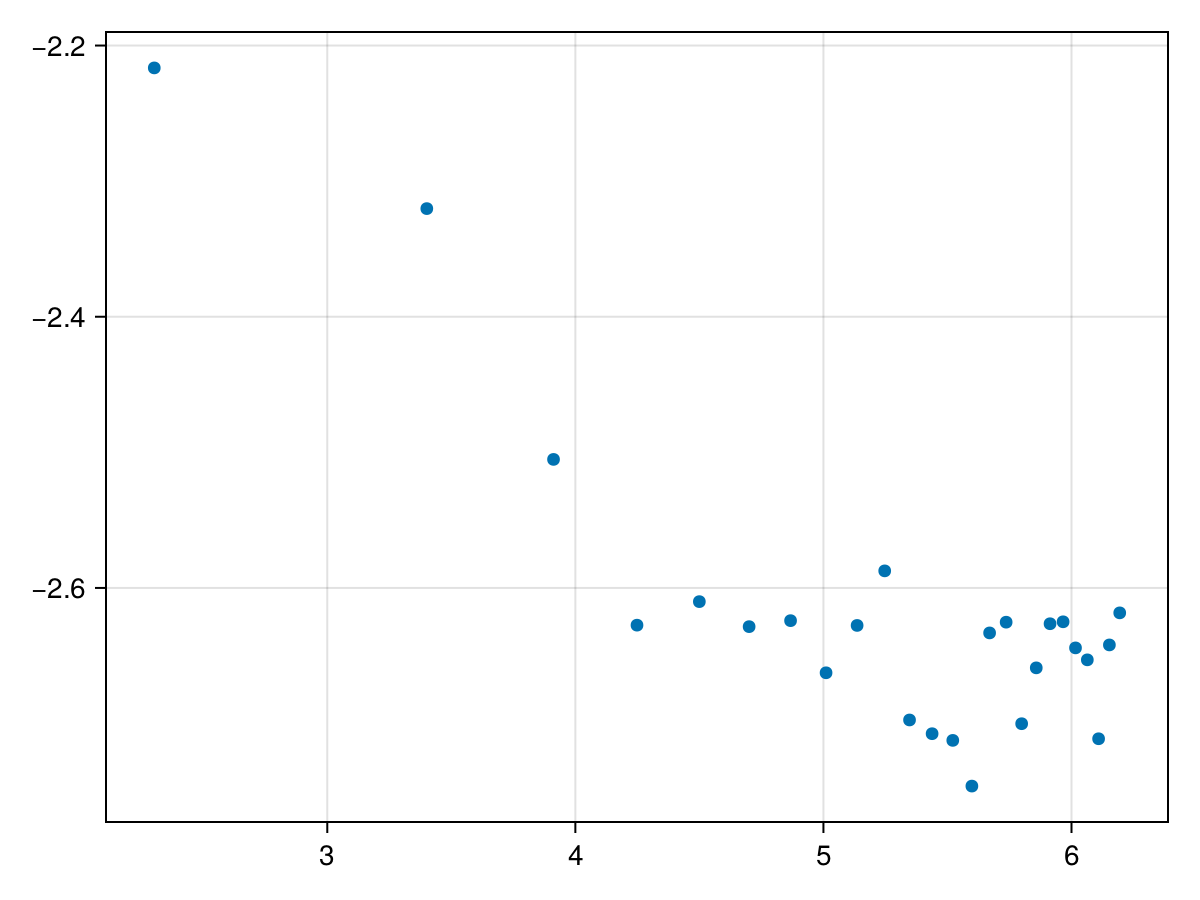

In [143]:
plot(log.(M_vec), log.(mean(m, dims = 2)[:]))

In [7]:
function λ(l)
    Λ = fill(l, N)
    s = MiCRM_stability.get_structural_params(c.U,c.D, Λ)
    p = MiCRM_stability.Parameters(N,M,s,e)
    
    #jaccobian
    J = zeros(N+M, N+M)
    MiCRM_stability.jacobian!(p, J)
    
    return(eigen(J), J)
end

λ (generic function with 1 method)

In [8]:
lvec = fill(0.01, 25)
l = λ.(lvec);

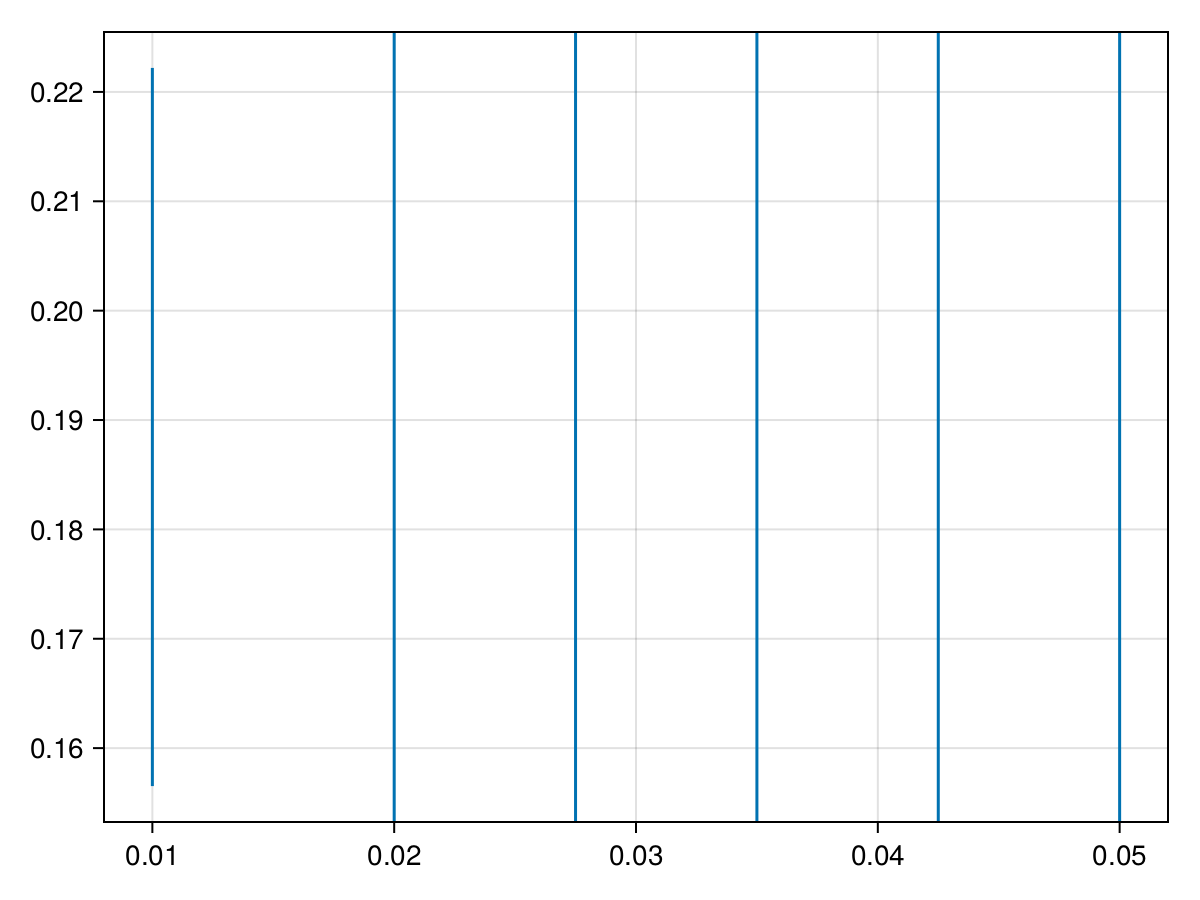

In [9]:
f,ax = lines(lvec, [l[1].values[end].re for l = l])
l_vec = range(0.02, 0.05, length = 5)
vlines!(ax, l_vec)
f

In [204]:

# l_vec = range(0.15, 0.2, length = 5)

f = Figure(size = (1000,400))

for i = 1:5
    x,xJ = λ(l_vec[i])
    
    ax = Axis(f[1,i])
    plot!(norm.(x.vectors)', colorrange = (0, 1)) 
    
    a = real(x.values)
    b = imag(x.values)
    
    ax = Axis(f[2,i])

    ce = diag(xJ)
    ra = sum(abs.(xJ), dims = 2)[:] .- abs.(ce)
    
    scatter!(ax,a,b)
    vlines!(ax, [0.0])

    
    
end

linkaxes!(f.content[[2,4,6,8,10]]...)

f



LoadError: DimensionMismatch: A has dimensions (200,200) but B has dimensions (100,100)

┌ Warning: Since there are a lot of edges (4457 > 500), they will be drawn as straight lines even though they contain curvy edges. If you really want to plot them as bezier curves pass `edge_plottype=:beziersegments` explicitly. This will have much worse performance!
└ @ GraphMakie ~/.julia/packages/GraphMakie/cSPi5/src/recipes.jl:532


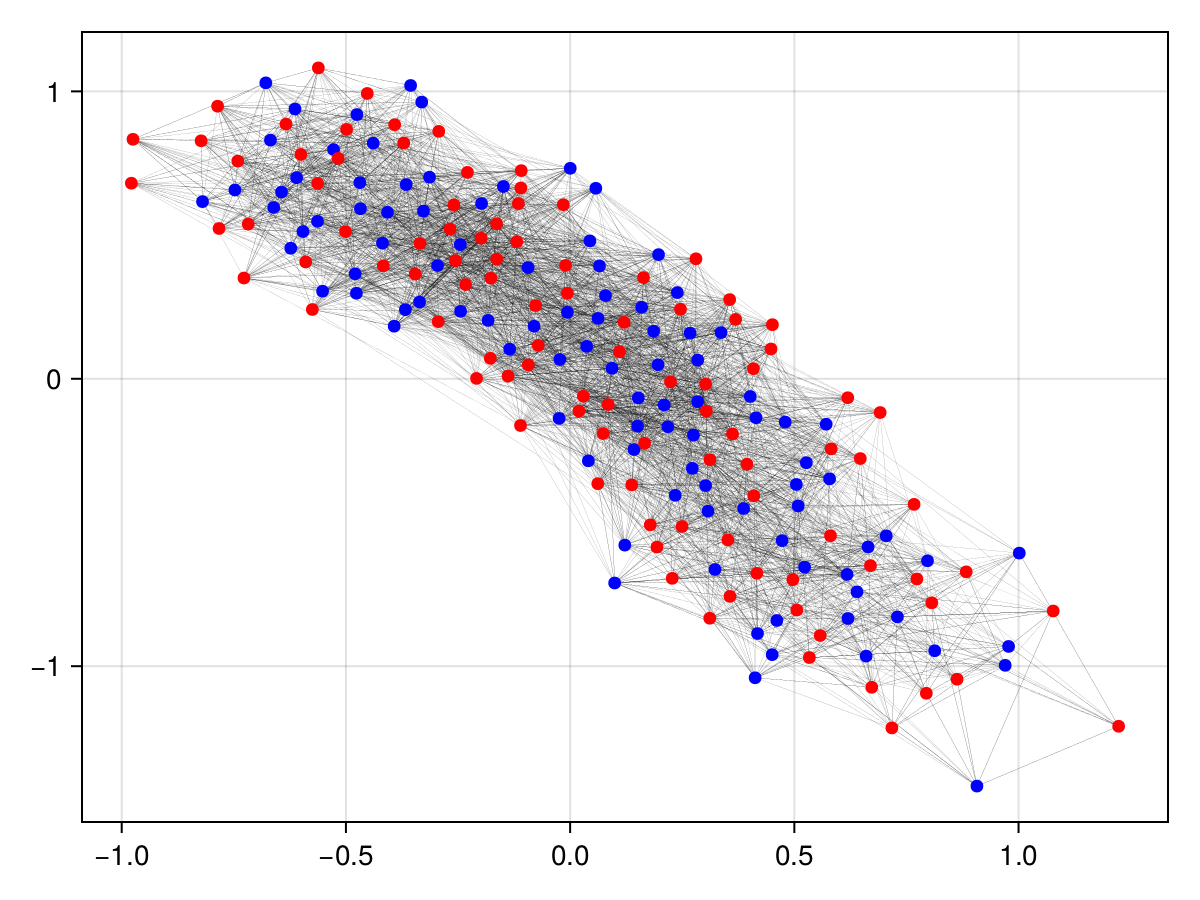

In [58]:
com = MiCRM_stability.niche_model(N,M, 10, 100)
K = com.U * com.D 

A = zeros(N+M , N+M)

A[1:N, N+1:end] .= K
A[N+1 : end, 1:N] .= com.U

g = Graphs.DiGraph(A)

c = fill(:red, N+M)
c[1:N] .= :blue
graphplot(g, node_color = c, edge_width = 0.05, arrow_size = 0.01)

In [63]:
#create two communties one structured and one shuffled
function niche_community(N,M,f,l)
    com = MiCRM_stability.niche_model(N,M, l, l)
    Λ = fill(0.001, N)
    
    s = MiCRM_stability.get_structural_params(com.U,com.D, Λ)
    e = f(N,M, 0.1)
    
    p = MiCRM_stability.Parameters(N,M,s,e)

    return(p,com,e)
end

function λ(l)
    Λ = fill(l, N)
    s = MiCRM_stability.get_structural_params(com.U,com.D, Λ)
    p = MiCRM_stability.Parameters(N,M,s,e)
    
    #jaccobian
    J = zeros(N+M, N+M)
    MiCRM_stability.jacobian!(p, J)
    
    return(eigen(J), J)
end

# #functions for simulations
function get_exponential_parameters(N::Int64,M::Int64,σ::Float64)
    gx = rand(Uniform(σ,2.0)) .+ rand(Uniform(-σ,σ), N)
    gs = rand(Uniform(σ,2.0)) .+ rand(Uniform(-σ,σ), N)
    mx = rand(Uniform(0.8,2.0)) .+ rand(Uniform(-σ,σ), N)
    
    fy = rand(Uniform(0,2)) .+ rand(Uniform(-σ,σ),N,M) 
    λy = zeros(N,M)

    iy = zeros(M)
    oy = ones(M)

    return MiCRM_stability.exponential_params(gx,gs,mx,fy,λy,iy,oy)
end


get_exponential_parameters (generic function with 1 method)

In [64]:
N,M = 100,100

rep = 1000
xvec = zeros(rep)
kvec = zeros(rep)

Threads.@threads for i = 1:rep
    K = rand() * 10
    kvec[i] = K
    p,com,e = niche_community(N,M, get_exponential_parameters,K)
        
    Λ = fill(0.1, N)
    s = MiCRM_stability.get_structural_params(com.U,com.D, Λ)
    p = MiCRM_stability.Parameters(N,M,s,e)
    
    #jaccobian
    J = zeros(N+M, N+M)
    MiCRM_stability.jacobian!(p, J)

    xvec[i] = eigen(J).values[end] |> real
end


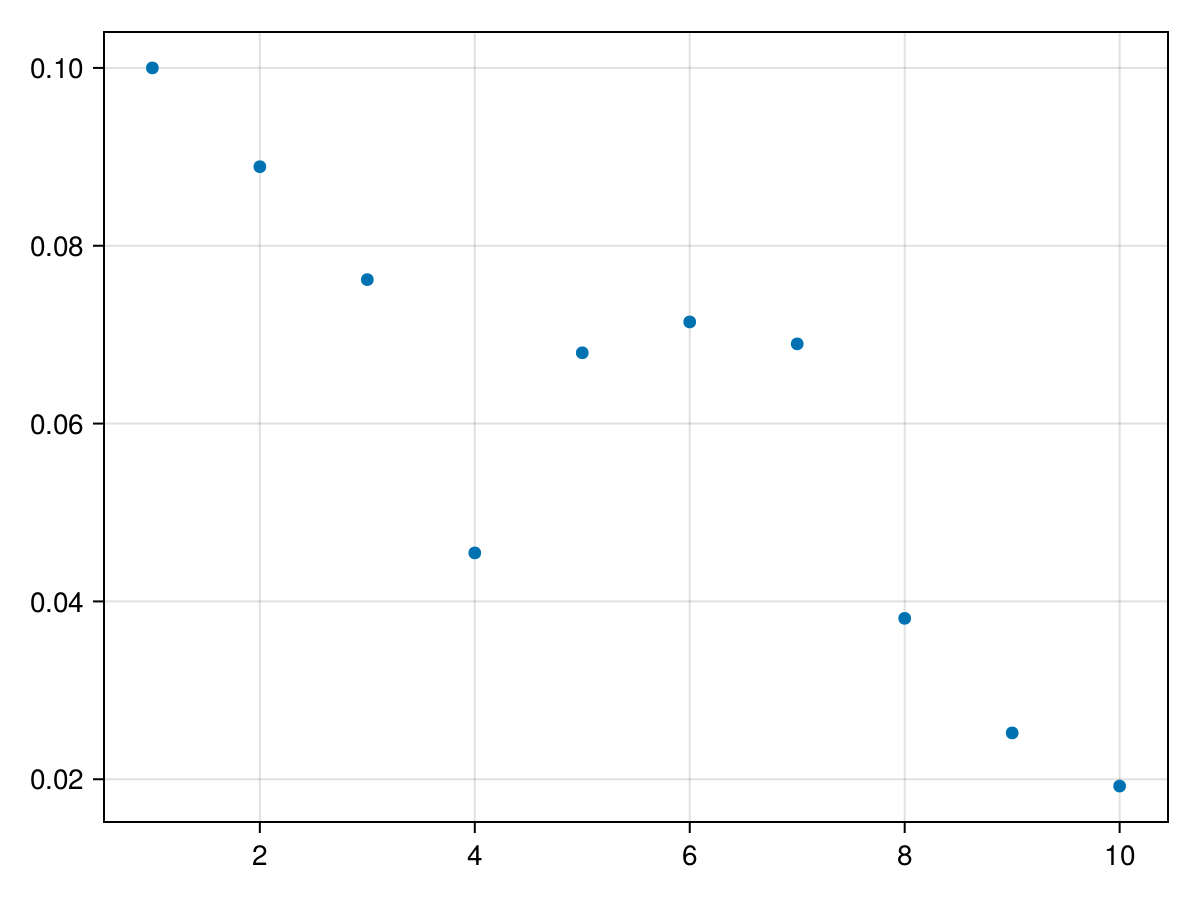

In [61]:
d = 1.0
x_vec = minimum(kvec):d:maximum(kvec) 

stab = xvec .< 0.0


[stab[i .< kvec .< i+d] |> mean for i = x_vec] |> plot

In [62]:
cor(kvec, xvec .< 0)

-0.09772727755623475

In [696]:
N,M = 100,100
p,com,e = niche_community(N,M, get_exponential_parameters,100)

K = com.U * com.D 
A = zeros(N+M , N+M)
A[1:N, N+1:end] .= K
A[N+1 : end, 1:N] .= com.U

g = Graphs.DiGraph(A)

λ(0.01)[1].values[end]

-0.007245991323832744 + 0.0im

In [689]:
λ(0.99)[1].values[end]

18.276187847239186 + 0.0im

┌ Warning: Since there are a lot of edges (4258 > 500), they will be drawn as straight lines even though they contain curvy edges. If you really want to plot them as bezier curves pass `edge_plottype=:beziersegments` explicitly. This will have much worse performance!
└ @ GraphMakie ~/.julia/packages/GraphMakie/cSPi5/src/recipes.jl:532


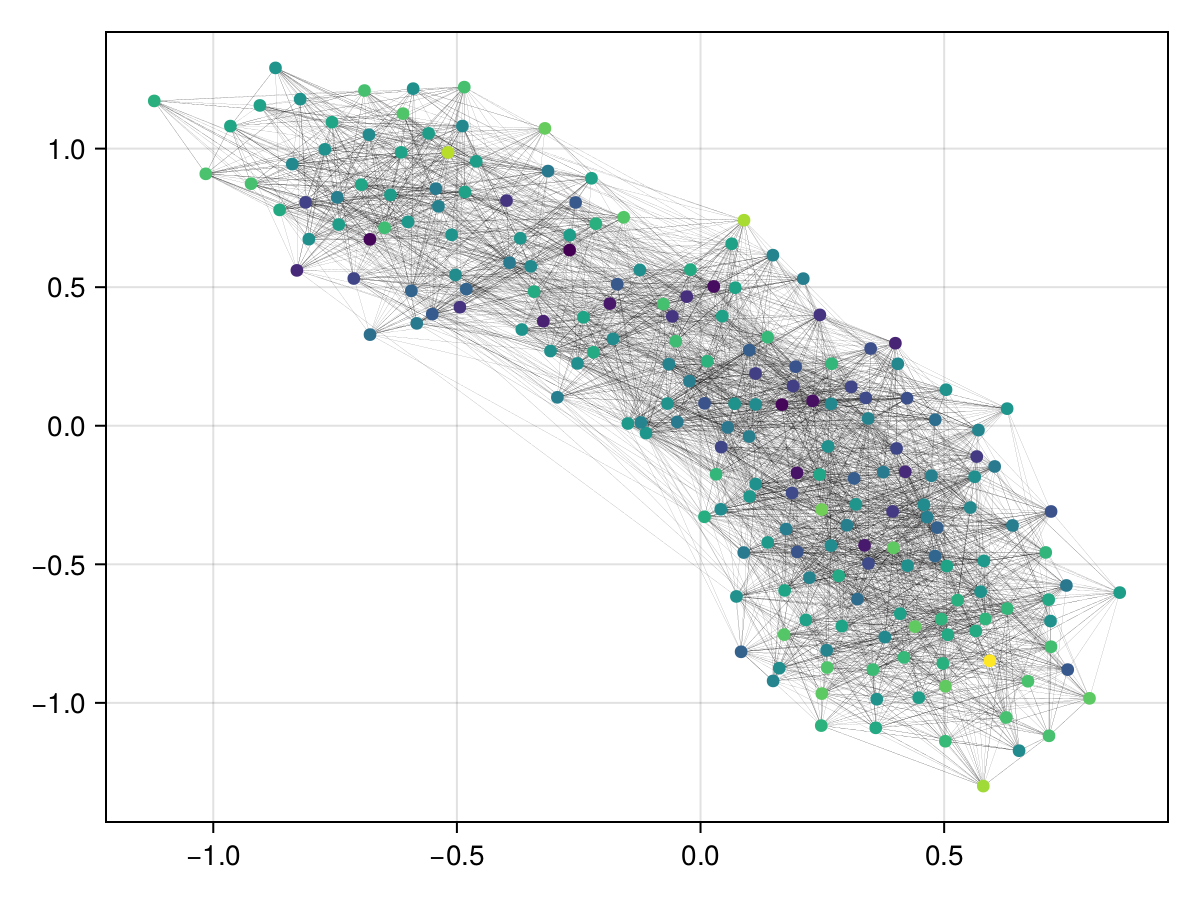

In [692]:
c = eigenvector_centrality(g)
se = norm.(MiCRM_stability.se(λ(0.001)[2])) 
im_ = norm.(MiCRM_stability.im(λ(0.99)[2])) 

c = fill(:red, N+M)
c[1:N] .= :blue

graphplot(g, node_color = se, edge_width = 0.05, arrow_size = 0.01)

In [171]:
ys

100×101 Matrix{Float64}:
 1.0  0.0         0.0         …  0.0          0.0         0.0
 1.0  0.0         0.0            0.0          0.0         0.0
 1.0  0.0         0.00092812     0.00022761   0.00432461  0.00688327
 1.0  0.00178274  0.00251535     0.000752486  0.00483642  0.00814914
 1.0  0.00258429  0.00336762     0.00140376   0.0051436   0.0086633
 1.0  0.00294513  0.00375048  …  0.00171307   0.00524702  0.00891234
 1.0  0.00313247  0.00391677     0.00185899   0.00529282  0.00902261
 1.0  0.0032208   0.00399743     0.00192556   0.00531457  0.00907609
 1.0  0.00326332  0.00403582     0.00195801   0.00532531  0.00910129
 1.0  0.0032835   0.00405423     0.00197358   0.00533047  0.00911337
 1.0  0.00329319  0.00406303  …  0.00198108   0.00533295  0.00911913
 1.0  0.00329785  0.00406724     0.00198468   0.00533414  0.0091219
 1.0  0.00330008  0.00406926     0.00198641   0.00533471  0.00912322
 ⋮                            ⋱                           ⋮
 1.0  0.00330213  0.00407112     0

In [124]:
y


101-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [86]:
function niche_model(N,M,C; nC = rand(N), nR = rand(M))
    #sorting
    nC = nC[[p for p = nC] |> sortperm]
    nR = nR[[p for p = nR] |> sortperm]
    
    eff_C = 1 - sqrt(1 - C)
    RC = rand(Beta(1, (1/eff_C) - 1), N)
    RR = rand(Beta(1, (1/eff_C) - 1), M)
    
    U = zeros(N,M)
    D = zeros(M,M)
    
    for i = 1:N
        dn = abs.(nC[i] .- nR) 
        if all(dn .> RC[i])
            U[i,findmin(dn)[2]] = 1
        else
            U[i,findall(dn .< RC[i])] .= 1
        end
        U[i,:] .= U[i,:] ./ sum(U[i,:])
    end
    
    U[isnan.(U)] .= 0.0
    
    for i = 1:M
        dn = abs.(nR[i] .- nR) 
        if all(dn .> RR[i])
            D[i,findmin(dn)[2]] = 1
        else
            D[i,findall(dn .< RR[i])] .= 1
        end
        D[i,:] .= D[i,:] ./ sum(D[i,:])
    end
    
    D[isnan.(D)] .= 0.0

    return MiCRM_stability.Community(N,M,U,D)
end

niche_model (generic function with 1 method)

In [163]:
function niche_axis(a, N)
    d = rand(Distributions.Pareto(a,1), N)
    return(cumsum(d) ./ sum(d))
end

niche_axis (generic function with 1 method)

In [314]:
# structural_overlap(c)
c = niche_model(100,100, 0.01)
U = c.U .> 0



0.036199999999999996

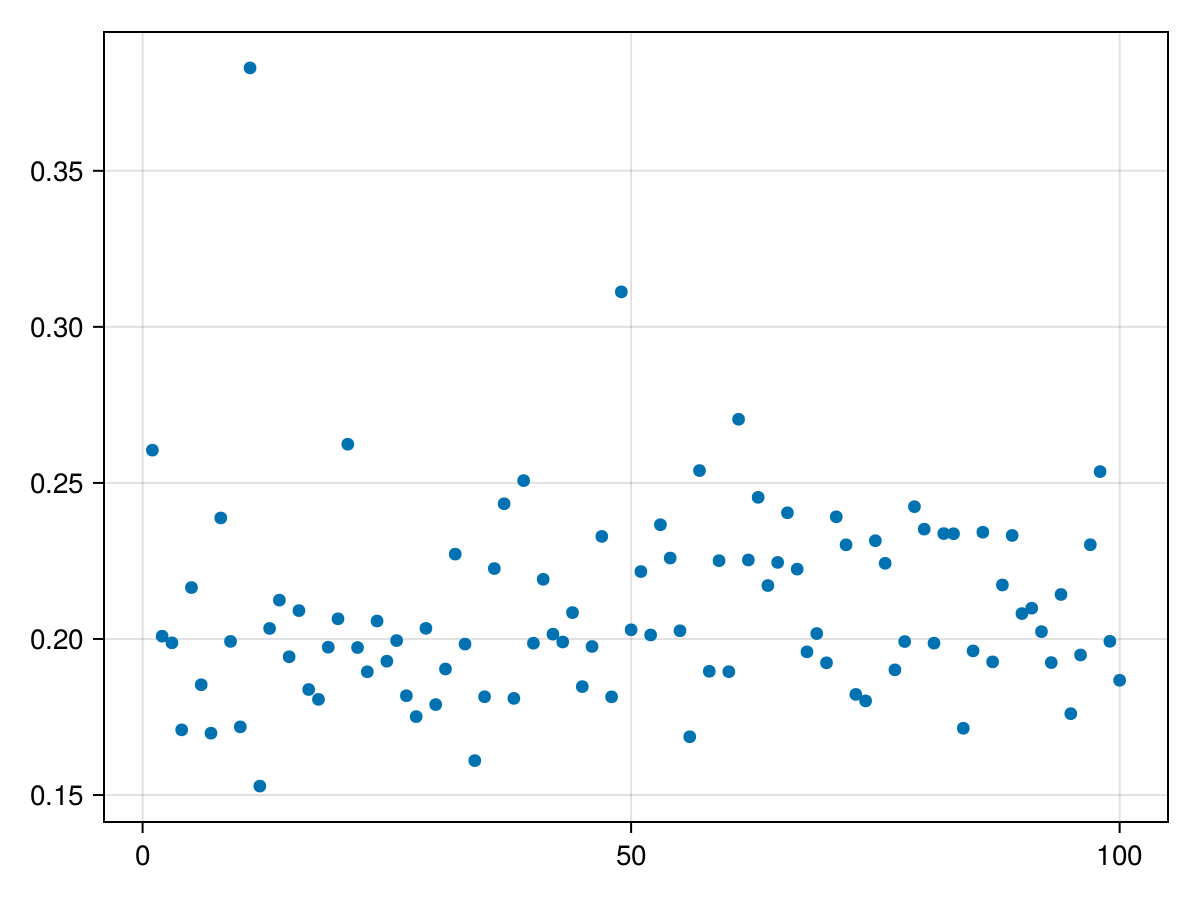

In [168]:
μ = 0.5
σ0 = 0.2

C = 0.5 - σ0 * μ * 2
nC = 0.5 .+ rand(Uniform(-μ,μ), 100)

c = [jac(niche_model(100,100, 0.5, nC = niche_axis(2i / 100, 100))) for i = 1:100]

c |> plot

In [88]:
function niche_axis(a, N)
    d = rand(Distributions.Pareto(a,1), N)
    return(cumsum(d) ./ sum(d))
end

niche_axis (generic function with 1 method)

In [95]:
function jac(c)
    x = eachrow(c.U)
    [sum(min.(x[i],x[j])) / sum(max.(x[i],x[j])) for i = 1:(c.N-1) for j = (i+1):c.N] |> mean
end

jac (generic function with 1 method)

In [94]:
jac(c)

0.11282965718100407

In [4]:
#functions for simulations
function get_exponential_parameters(N,M,σ)
    gx = rand(Uniform(0.5,1.0), N)
    gs = rand(Uniform(0.0,2.0), N)
    mx = rand(Uniform(1.0,1.5), N)
    
    fy = ones(N,M)

    λy = zeros(N,M)

    iy = rand(Uniform(0.0,0.5), M)
    oy = rand(Uniform(1.0,1.5), N)

    return MiCRM_stability.exponential_params(gx,gs,mx,fy,λy,iy,oy)
end

function random_community(N,M,f,Cu,Cd,s)
    c = MiCRM_stability.random_community(N,M,Cu,Cd)
    c.U[c.U .!= 0] .= abs.( rand(Normal(1,s), sum( (c.U .!= 0)[:] ) ) )
    Λ = fill(rand(),N)
    
    s = MiCRM_stability.get_structural_params(c.U,c.D,Λ, 2rand())
    e = f(N,M, 0.1)

    p = MiCRM_stability.Parameters(N,M,s,e)
    # push!(p.tmp, MiCRM_stability.calculate_g_s(p))

    return(p)
end

function modular_community(N, M, f, C, r)
    c = MiCRM_stability.modular_community(N,M,C,5,r)
    # c.U[c.U .!= 0] .= abs.( rand(Normal(1,s), sum( (c.U .!= 0)[:] ) ) )
    Λ = fill(rand(),N)
    
    s = MiCRM_stability.get_structural_params(c.U,c.D,Λ)
    e = f(N,M, 0.1)

    p = MiCRM_stability.Parameters(N,M,s,e)

    return(p,c.U)
end

modular_community (generic function with 1 method)

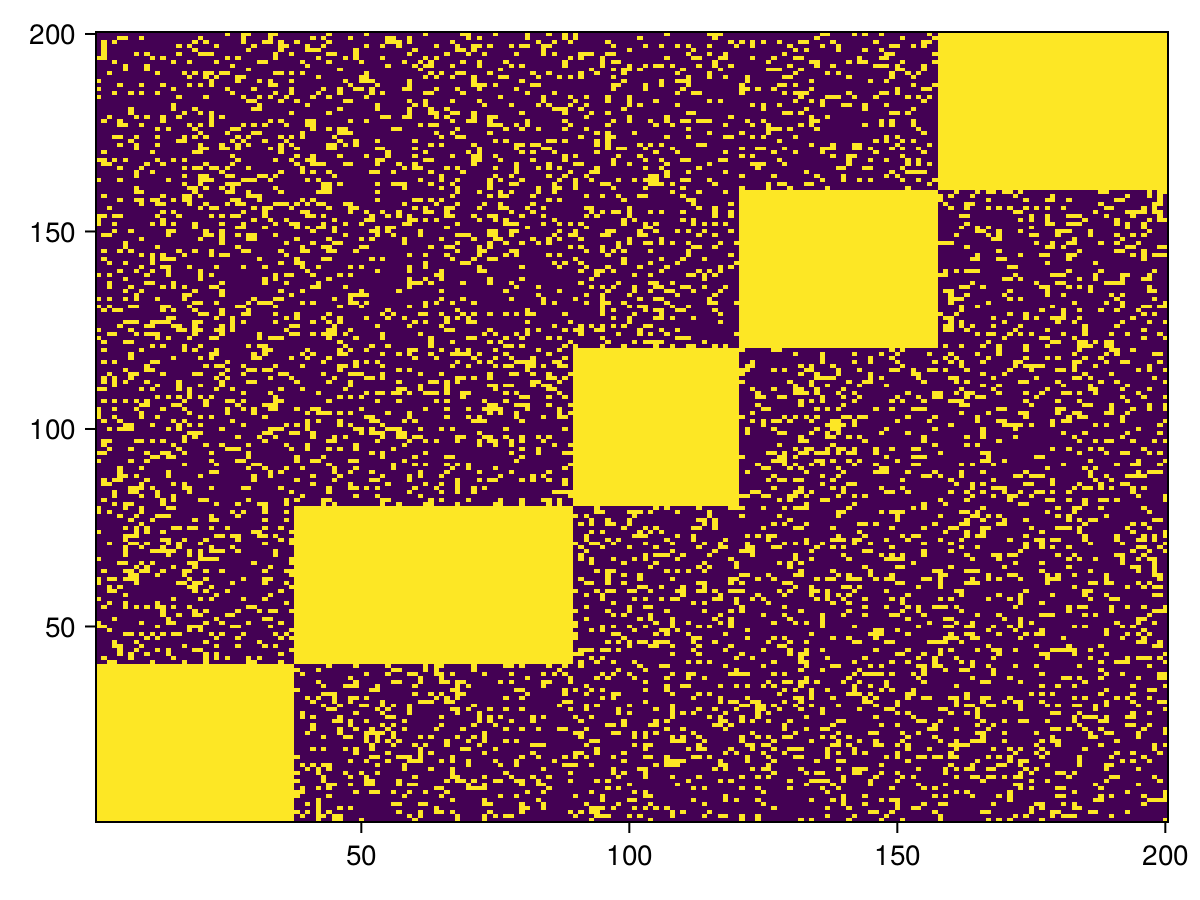

In [25]:
# resource model
N = 200
M = 200

Cu,Cd = 1/M, 0.1
s = 0.1
f = get_exponential_parameters

c = modular_community(N,M,f,0.5,0.1)

c[2] |> heatmap
# Λ = fill(0.01,N)

# s = MiCRM_stability.get_structural_params(c.U,c.D,Λ)
# e = f(N,M, 0.1)

# p = MiCRM_stability.Parameters(N,M,s,e)

# Utot = sum(c.U, dims = 1)[:]
# K = diagm(Λ) * c.U * c.D
# Ktot = sum(K, dims = 1)[:]

# EF = (Utot .- Ktot)

# [EF[i] > 0 ? EF[i] / (EF[i] + Ktot[i]) : abs(EF[i]) / (abs(EF[i]) + Utot[i]) for i = 1:M] |> plot

In [46]:
N,M= 100,100
Cu,Cd = 0.3,0.3
s=1e-6
f = get_exponential_parameters

@time c = MiCRM_stability.random_community(N,M,Cu,Cd)
@time Λ = fill(rand(),N)
    
@time s = MiCRM_stability.get_structural_params(c.U,c.D,Λ, 2rand())
@time e = f(N,M, 0.1)
@time p = MiCRM_stability.Parameters(N,M,s,e);
    # push!(p.tmp, MiCRM_stability.calculate_g_s(p))


  0.000130 seconds (217 allocations: 497.594 KiB)
  0.000007 seconds (2 allocations: 912 bytes)
  0.007813 seconds (71.56 k allocations: 61.398 MiB)
  0.000021 seconds (15 allocations: 165.156 KiB)
  0.000001 seconds (1 allocation: 176 bytes)


In [1]:
function nested_community(N,M,κ,v, Nin, Nout)
    U = zeros(N,M)
    L = zeros(N,M)

    p = (1.0:M) .^ κ
    p = p ./ sum(p)
    
    kU = sample(1:M, Weights(p), N) |> sort |> reverse
    kL = sample(1:M, Weights(p), N) |> sort |> reverse
    
    for i = 1:N
        Z = kU[i]
        nj = (sum(U,dims=1)[:] .+ 1) .^ v
        p = nj ./ sum(nj)
        U[i,:] .= rand(Multinomial(Z,p)) .> 0

        Z = kL[i]
        nj = (sum(L,dims=1)[:] .+ 1) .^ v
        p = nj ./ sum(nj)
        L[i,:] .= rand(Multinomial(Z,p)) .> 0

        
    end
    ind = sortperm(sum(U .> 0, dims = 1)[:], rev = true)

    U[:,rand(1:M, Nout)] .= 0
    L[:,rand(1:M, Nin)] .= 0
    

    return(Community(N,M, U[:,ind] .* rand(N,M),  L[:,ind] .* rand(N,M)))
end

nested_community (generic function with 1 method)

In [157]:
#system size
N = 10
M = 10

#consumer values
Λ = 0.5 .+ randn(N)/100

α = zeros(N)
β = zeros(M)

#external supply structure
ρ = zeros(M)
ρ[[1,2]] .= 1.0

σ = zeros(M)
σ[[M-1,M]] .= 1.0

#set supplied resources to 1
β[ρ .== 1] .= 1.0
Itot = sum(β .* ρ)

#prop to mortality
ψ = 0.5
Mtot = Itot * ψ
Otot = Itot * (1-ψ)

β[σ .> 0] .= Otot .* σ[σ .> 0] ./ sum(σ)

β

10-element Vector{Float64}:
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.5
 0.5

In [158]:
#provide relative fluxes
χ = Float64.(rand(N,M) .< 0.5)
[χ[i,:] .= χ[i,:] ./ sum(χ[i,:]) for i = 1:N]
χ

10×10 Matrix{Float64}:
 0.166667  0.166667  0.0       0.0       …  0.166667  0.166667  0.166667
 0.0       0.166667  0.0       0.166667     0.166667  0.166667  0.166667
 0.0       0.0       0.0       0.0          0.166667  0.166667  0.166667
 0.2       0.2       0.2       0.0          0.0       0.0       0.0
 0.0       0.2       0.0       0.0          0.0       0.0       0.2
 0.0       0.25      0.0       0.0       …  0.25      0.0       0.0
 0.0       0.0       0.0       0.142857     0.142857  0.142857  0.142857
 0.0       0.0       0.142857  0.142857     0.142857  0.142857  0.142857
 0.142857  0.142857  0.142857  0.142857     0.0       0.142857  0.0
 0.166667  0.0       0.166667  0.0          0.166667  0.166667  0.166667

In [164]:
sum(χ[:,ρ .== 1])

1.8023809523809524

In [163]:
Mtot

1.0

In [280]:
x = zeros(M,200)
x[1,1] = 1.0

for i = 2:200
    x[:,i] = c.D' * (sum(c.U,dims=1)[:] .* x[:,i-1]) 
    x[1,i] = 1
    x[end,i] = 0
    x[:,i] .= x[:,i] / sum(x[:,i]) 
end

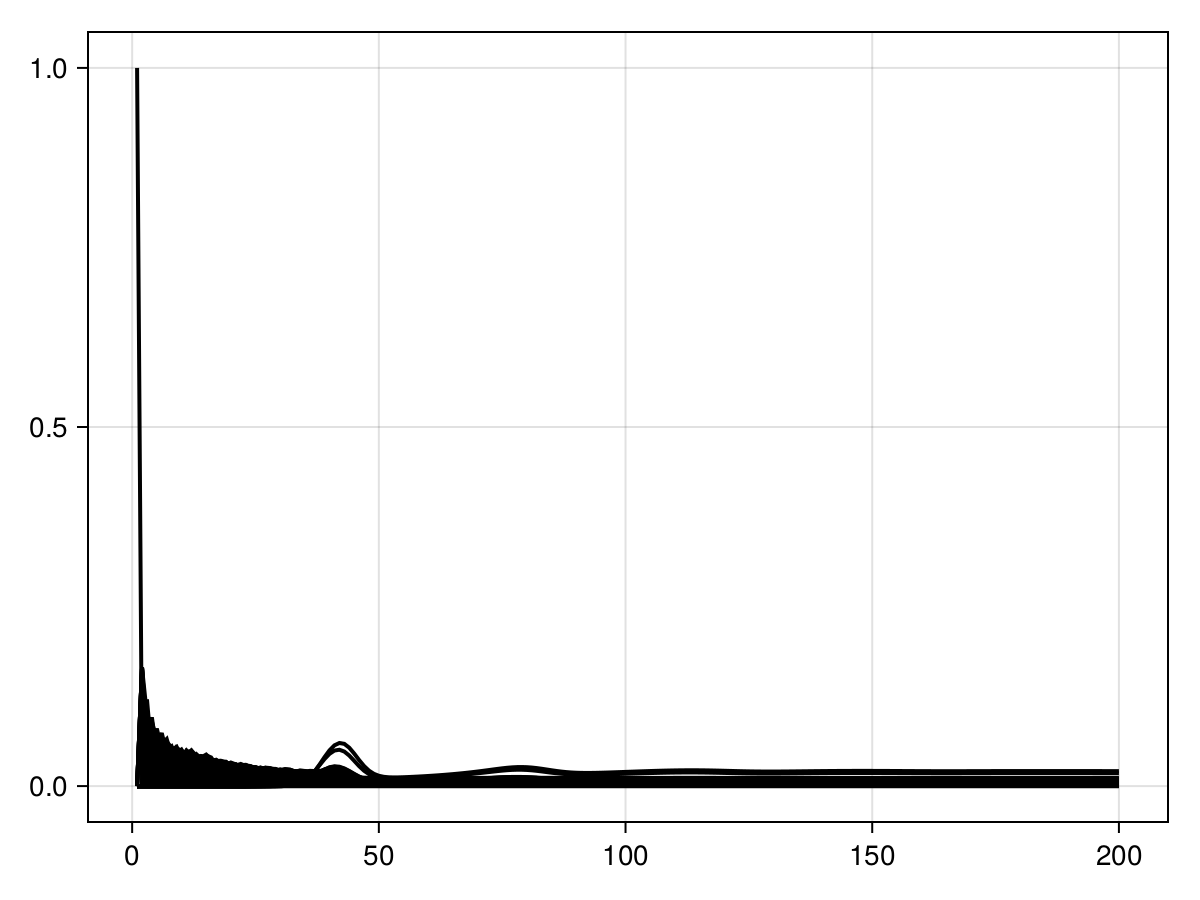

In [281]:
series(x,solid_color = :black)

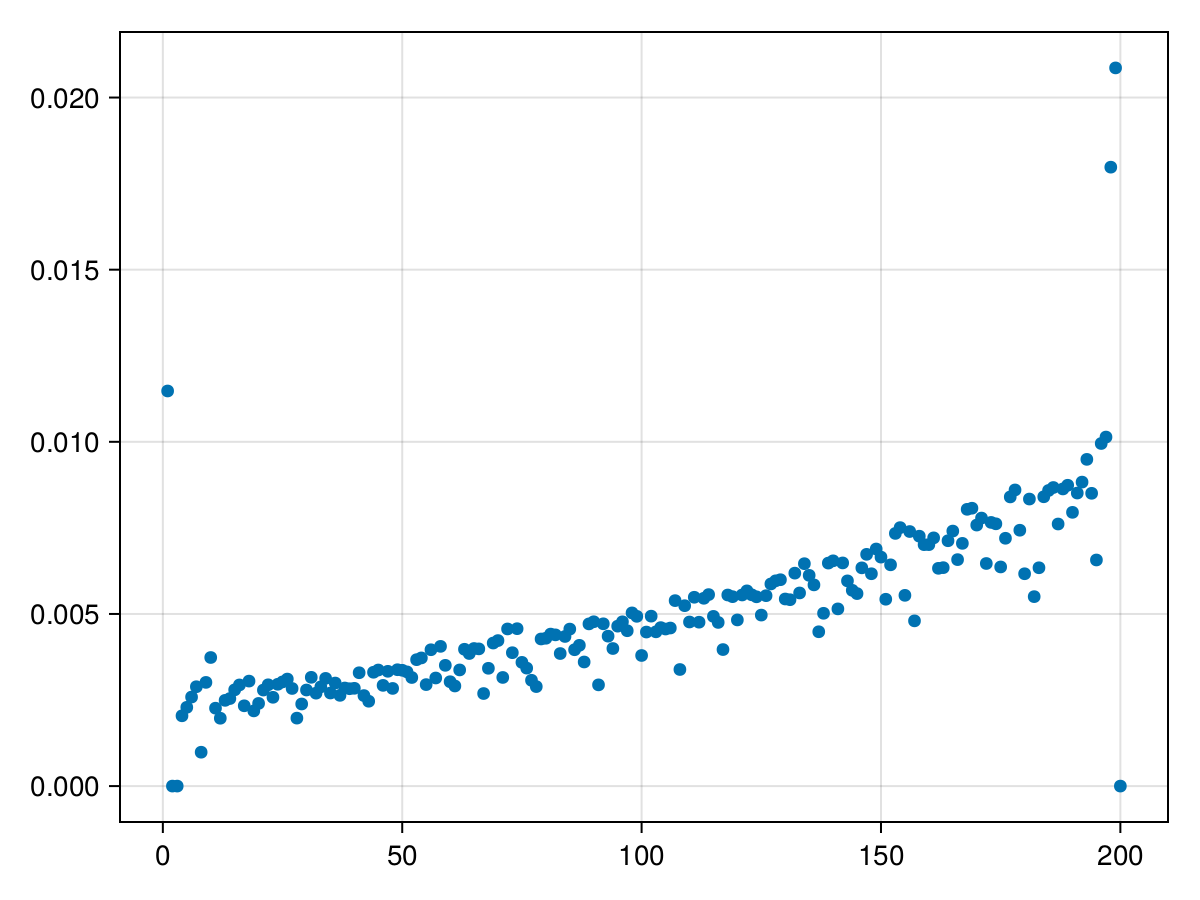

In [282]:
x[:,end] |> plot

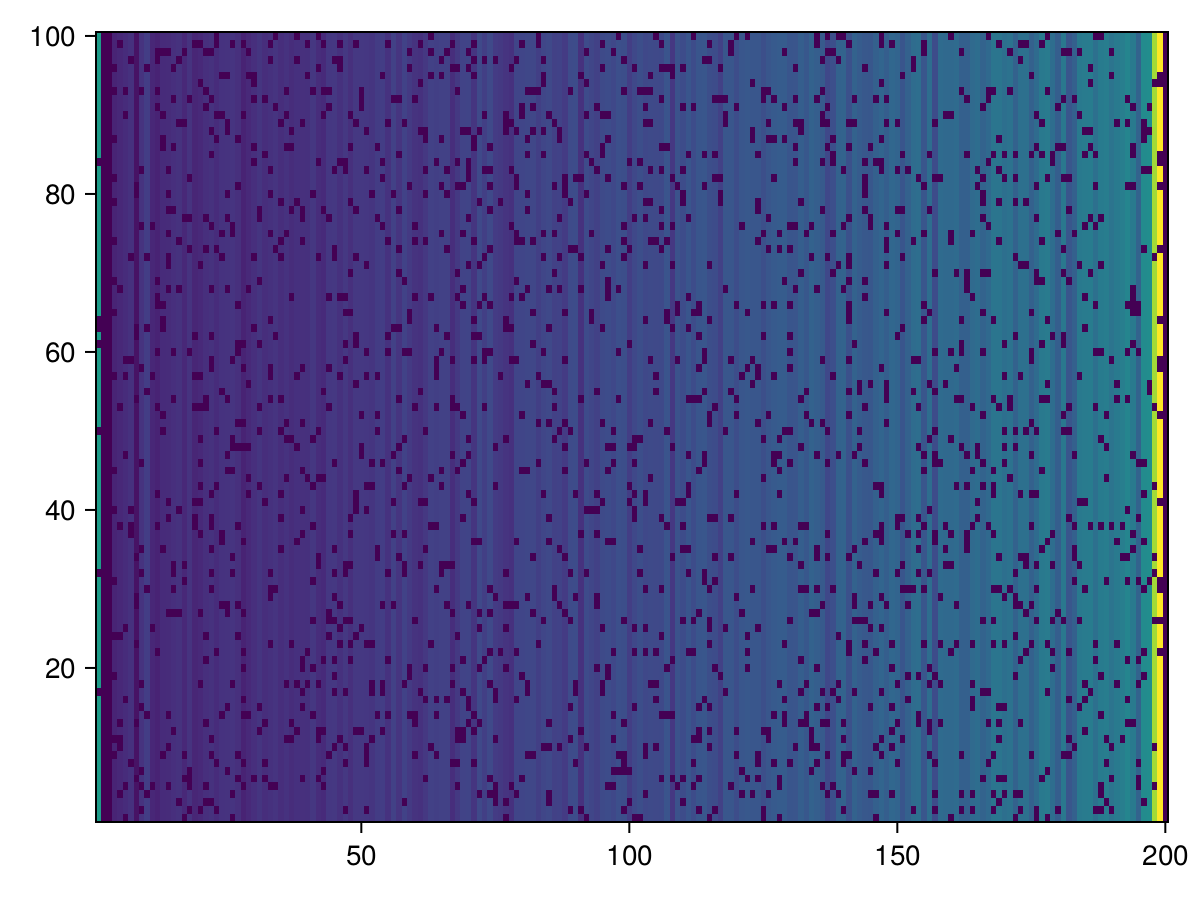

In [289]:
(x[:,end] .* c.U') |> heatmap

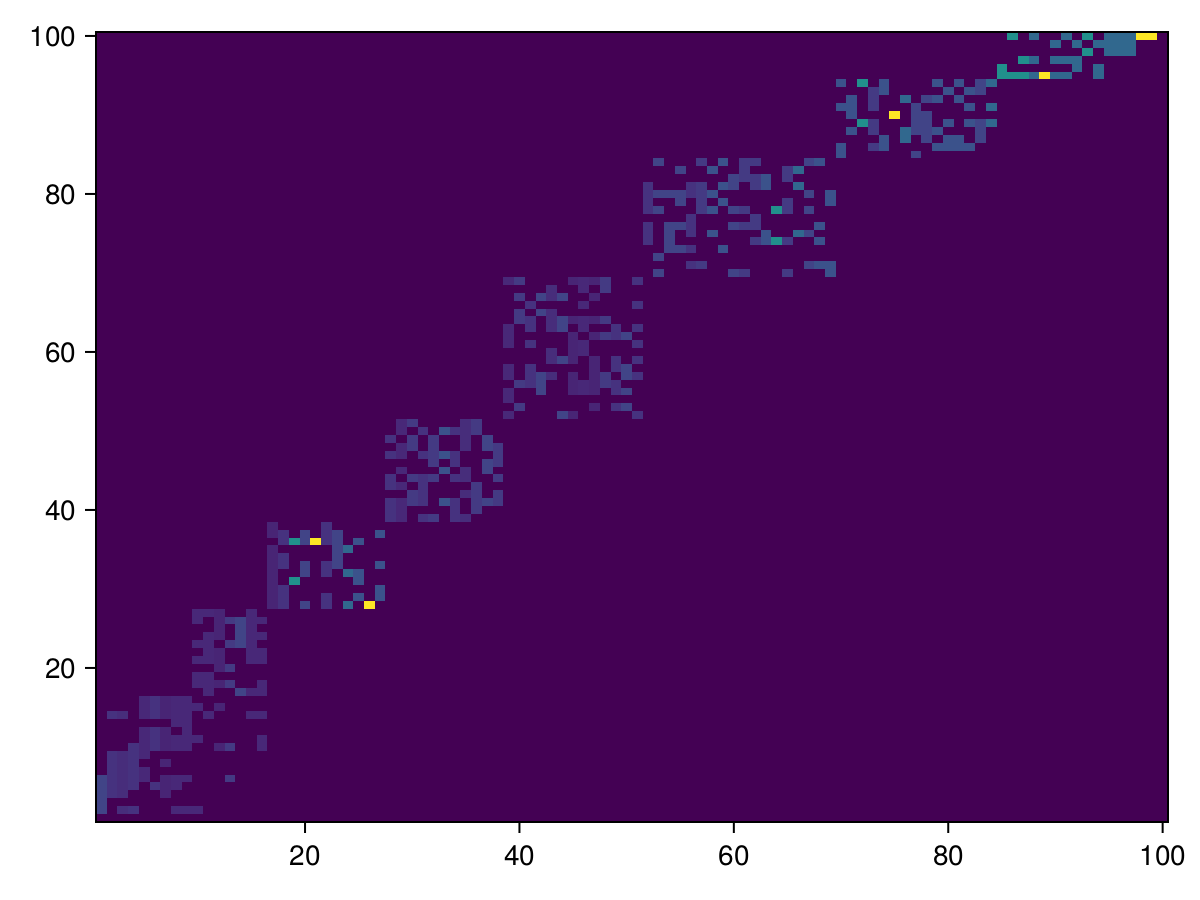

In [300]:
function random_community(N,M,f,C,h,T)
    c = MiCRM_stability.coherent_community(N,M,C, Int(floor(M*C)), h, T)
    Λ = fill(rand(),N)
    
    s = MiCRM_stability.get_structural_params(c.U, c.D, Λ, rand())
    e = f(N,M, 0.1)
    
    p = MiCRM_stability.Parameters(N,M,s,e)

    return(p)
end


N,M,C = 100,100,0.5
c = MiCRM_stability.coherent_community(100,100,C, 5, 1, 0.01)
Λ = fill(rand(),N)
s = MiCRM_stability.get_structural_params(c.U, c.D, Λ, rand())
e = get_exponential_parameters(N,M, 0.1)
    p = MiCRM_stability.Parameters(N,M,s,e)

c.D |> heatmap

In [254]:
#mixed network
U = rand(N,M) ./ (N*M)
    # U[:,end] .= 0  
D = rand(M,M)
# D[:,1] .= 0
[D[i,:] .= D[i,:] ./ sum(D[i,:]) for i = 1:M]

Λ = fill(0.3,N)

#get K matrix
G = sum(U,dims=2)[:]
#uptake branching terms
χ = U ./ (norm.(eachrow(U), 1)) #resources to consumer uptake
γ = U ./ (norm.(eachcol(U), 1)') #consumers to resource loss
#by-product release term
K = G .* Λ .* (χ * D)

#release branching
η = K ./ (norm.(eachcol(K), 1)') #consumers to resource gain

γ[isnan.(γ)] .= 0.0 
η[isnan.(η)] .= 0.0 
χ[isnan.(χ)] .= 0.0 


0-element view(::Vector{Float64}, Int64[]) with eltype Float64

In [133]:
flux = sum(K,dims=1)[:] .- sum(U,dims=1)[:]

100-element Vector{Float64}:
 -0.004245721916000545
 -0.003870246592446851
 -0.0038304042232785852
 -0.0031206690655637987
 -0.003856727211623531
 -0.002951768358553259
 -0.0037584257766328528
 -0.003364769447314399
 -0.003366772689870903
 -0.004224155497242176
 -0.003266268128603164
 -0.0035844398014369576
 -0.0034686540255359022
  ⋮
 -0.0033442133177698733
 -0.003780819888658641
 -0.003506309608678383
 -0.004042164523664088
 -0.003030893836008343
 -0.0035985908615618857
 -0.003372846862670203
 -0.003520527500827029
 -0.004019292654686741
 -0.003407909147063997
 -0.003560892279905057
 -0.0033350295549361853

In [111]:
G .- M .- (G .* Λ)

100-element Vector{Float64}:
 2.168404344971009e-19
 2.168404344971009e-19
 4.336808689942018e-19
 2.168404344971009e-19
 4.336808689942018e-19
 2.168404344971009e-19
 2.168404344971009e-19
 4.336808689942018e-19
 2.168404344971009e-19
 2.168404344971009e-19
 2.168404344971009e-19
 2.168404344971009e-19
 2.168404344971009e-19
 ⋮
 4.336808689942018e-19
 2.168404344971009e-19
 4.336808689942018e-19
 2.168404344971009e-19
 4.336808689942018e-19
 4.336808689942018e-19
 2.168404344971009e-19
 4.336808689942018e-19
 2.168404344971009e-19
 0.0
 4.336808689942018e-19
 2.168404344971009e-19

0.003263710565766941

In [113]:
Apos = Matrix{Float64}(undef,N,N)
Aneg = Matrix{Float64}(undef,N,N)

for i = 1:N, j = 1:N
    int_neg = com.U[i,:] .*  com.U[j,:]
    if sum(int_neg .> 0) != 0
        Aneg[i,j] = mean(int_neg[int_neg .> 0])
    else
        Aneg[i,j] = 0
    end
    
    int_pos = com.U[i,:] .*  com.L[j,:]
    if sum(int_pos .> 0) != 0
        Apos[i,j] = mean(int_pos[int_pos .> 0])
    else
        Apos[i,j] = 0
    end
end

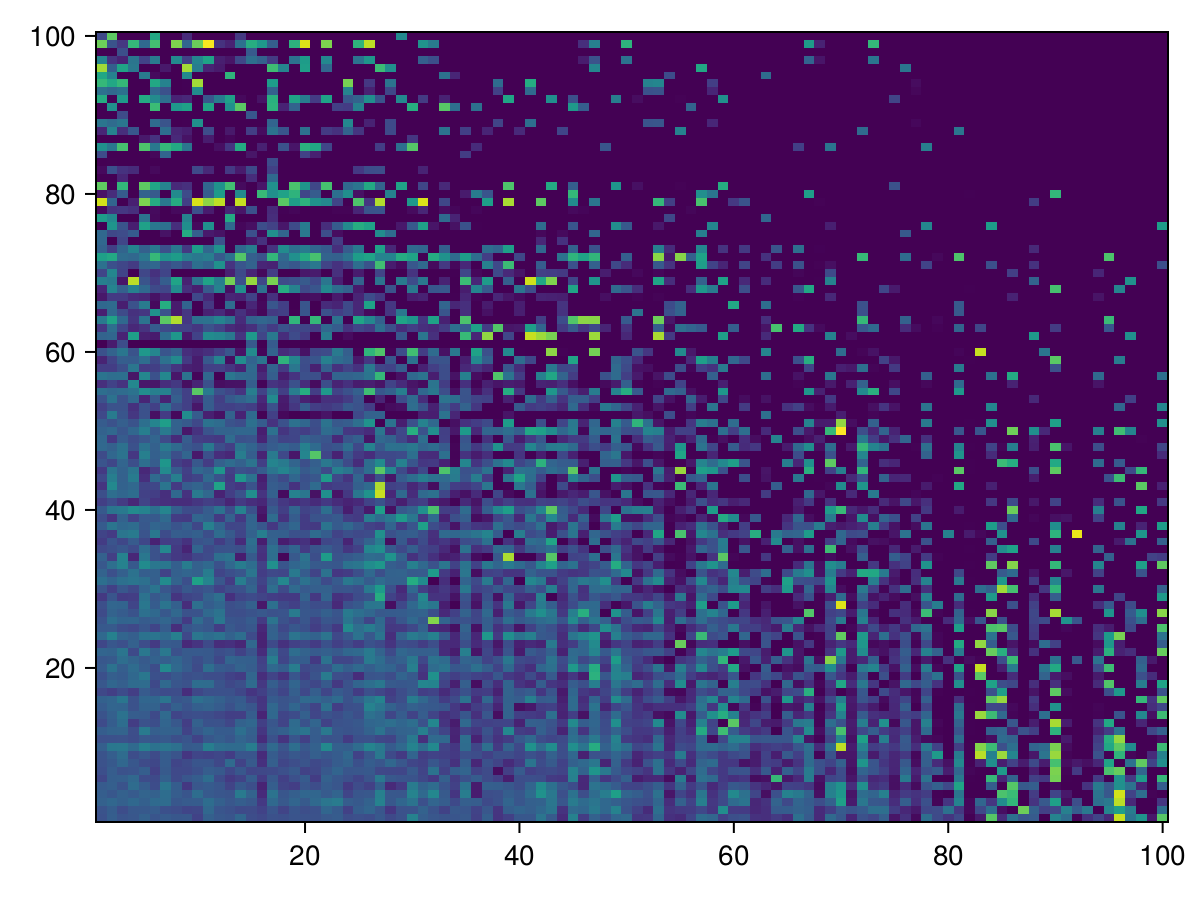

In [115]:
heatmap(Apos)

In [57]:
sum(Aneg) / Ntriples

-0.015563913766668585

In [5]:
# Resources
D = 3
M = 100

c = [rand(D) for i = 1:M]
c = c[sortperm([x[1] for x = c])]

#distance matrix
euclidian_dist(x,y) = sqrt(sum((x .- y).^2))
manhattan_dist(x,y) = sum(abs.(x .- y))

dist = fill(Inf,M,M)
for i = 1:M
    for j = 1:M
        if i == j
            dist[i,j] = Inf
        else
            if sum(c[i]) < sum(c[j])
                dist[i,j] = euclidian_dist(c[i],c[j])
            end
        end
    end
end

heatmap(dist)

LoadError: UndefVarError: `heatmap` not defined

In [6]:
#convert to probabilty
mp = 0.2
d_filter = filter(x -> !isinf(x), dist[:])
l = -log(mp) / mean(d_filter)
p = exp.(-l * dist)
heatmap(p)

LoadError: UndefVarError: `heatmap` not defined

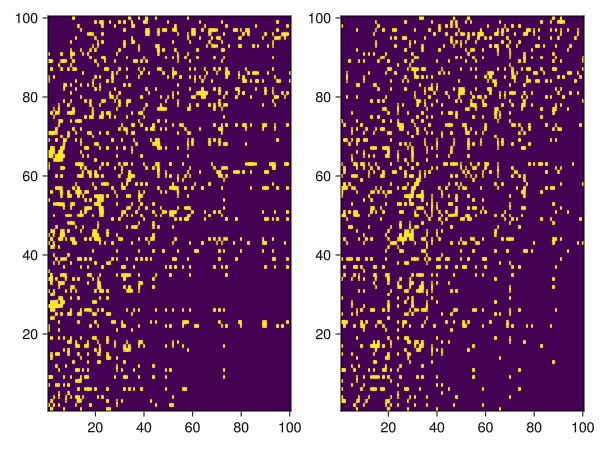

In [211]:
#convert to links
L = rand(M,M) .< p

k = sum(L,dims=1)[:]
f,ax = L[sortperm(k),:] |> heatmap

heatmap!(Axis(f[1,2]), L) 
f

In [166]:
points = Observable(Point2f[randn(2)])

fig, ax = scatter(points)
limits!(ax, -4, 4, -4, 4)

fps = 60
nframes = 120

fig

for i = 1:nframes
    fig
    new_point = Point2f(randn(2))
    points[] = push!(points[], new_point)
    sleep(1/fps) # refreshes the display!
end

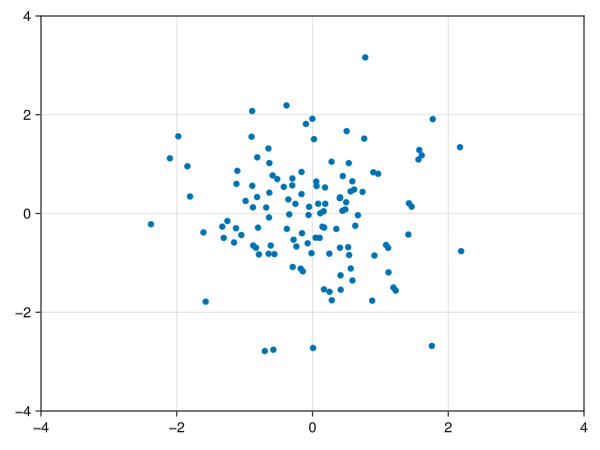

In [163]:
fig

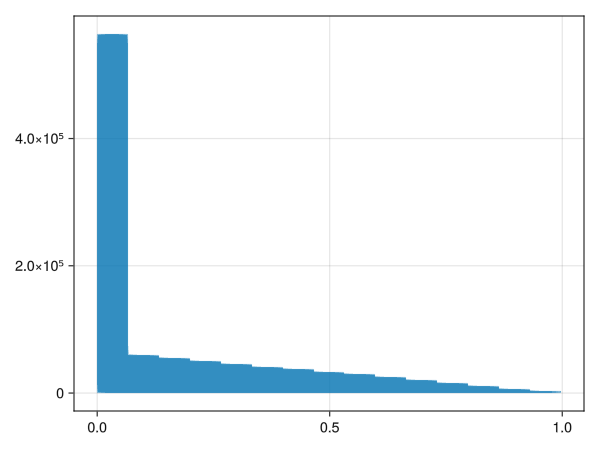

In [11]:
# Distribution of distances
n = rand(1000)

D = zeros(1000,1000)
for i = 1:1000
    for j = 1:1000
        D[i,j] = abs(n[i] - n[j])
    end
end

hist(UpperTriangular(D)[:])

In [12]:
#simulated overlap
function overlap(a,b,c,d)
    a,b,c,d = min.(1,[a,b,c,d])
    a,b,c,d = max.(0,[a,b,c,d])
    #do they overlap
    if (a <= d) & (c >= b)
        return min(c,d) - max(a,b)
    end
    return(0)
end


overlap (generic function with 1 method)

In [13]:
function d_overlap(N, w)
    n1 = rand(N)
    n2 = rand(N)

    c1 = rand(Beta(2,w),N)
    c2 = rand(Beta(2,w),N)



    return overlap.(n1 .- c1, n2 .- c2, n1 .+ c1, n2 .+ c2);

end

d_overlap (generic function with 1 method)

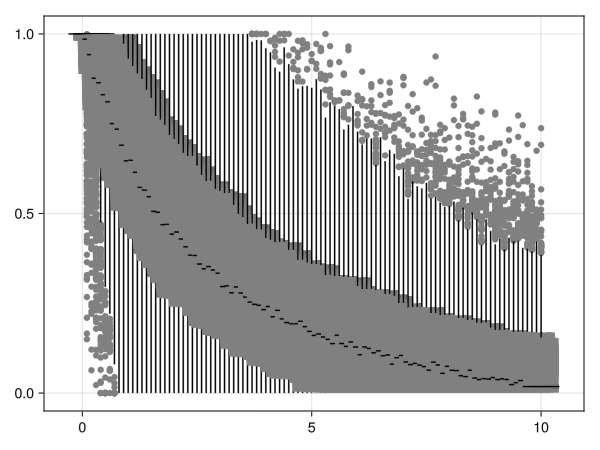

In [14]:
w = collect(0.1:0.1:10.0)
reps = 1000
O = [d_overlap(reps, w) for w = w]

f = Figure()

ax = Axis(f[1,1])

for i = eachindex(w)
    boxplot!(ax, fill(w[i], reps), O[i], color = :grey)
end

f

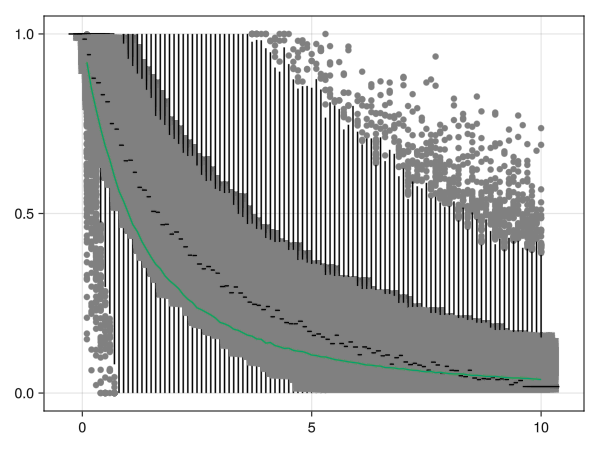

In [15]:
m = mean.([rand(Beta(2,b),10000).^2 for b = w])

lines!(ax, w, m)

# m = mean.([rand(Beta(2,b),10000) for b = w])
lines!(ax, w, m)

# m = mean.([rand(Beta(2,b),10000) for b = w]) .^ 2
lines!(ax, w, m)

f

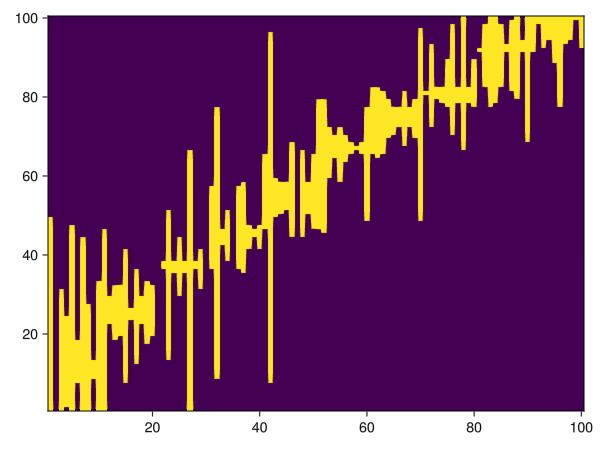

In [77]:
N = 100
M = 100

# n = rand(N) |> sort
d = rand(M) |> sort
n = repeat((1:10)/10, inner=10)

O = 0.01
β = sqrt(1/O) - 1
c = rand(Beta(1, β), N)

#calucate network
A = zeros(N,M)

for i = 1:N
    for j = 1:M
        if (n[i] - c[i] < d[j]) & (n[i] + c[i] > d[j])
            A[i,j] = 1
        end
    end
end

heatmap(A)

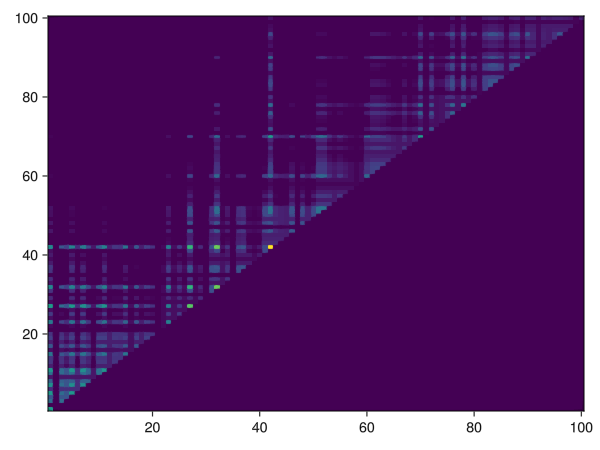

In [78]:
B = zeros(N,N)
for i = 1:N
    for j = i:N
        B[i,j] = mean(A[i,:] .* A[j,:])
    end
end

heatmap(B)

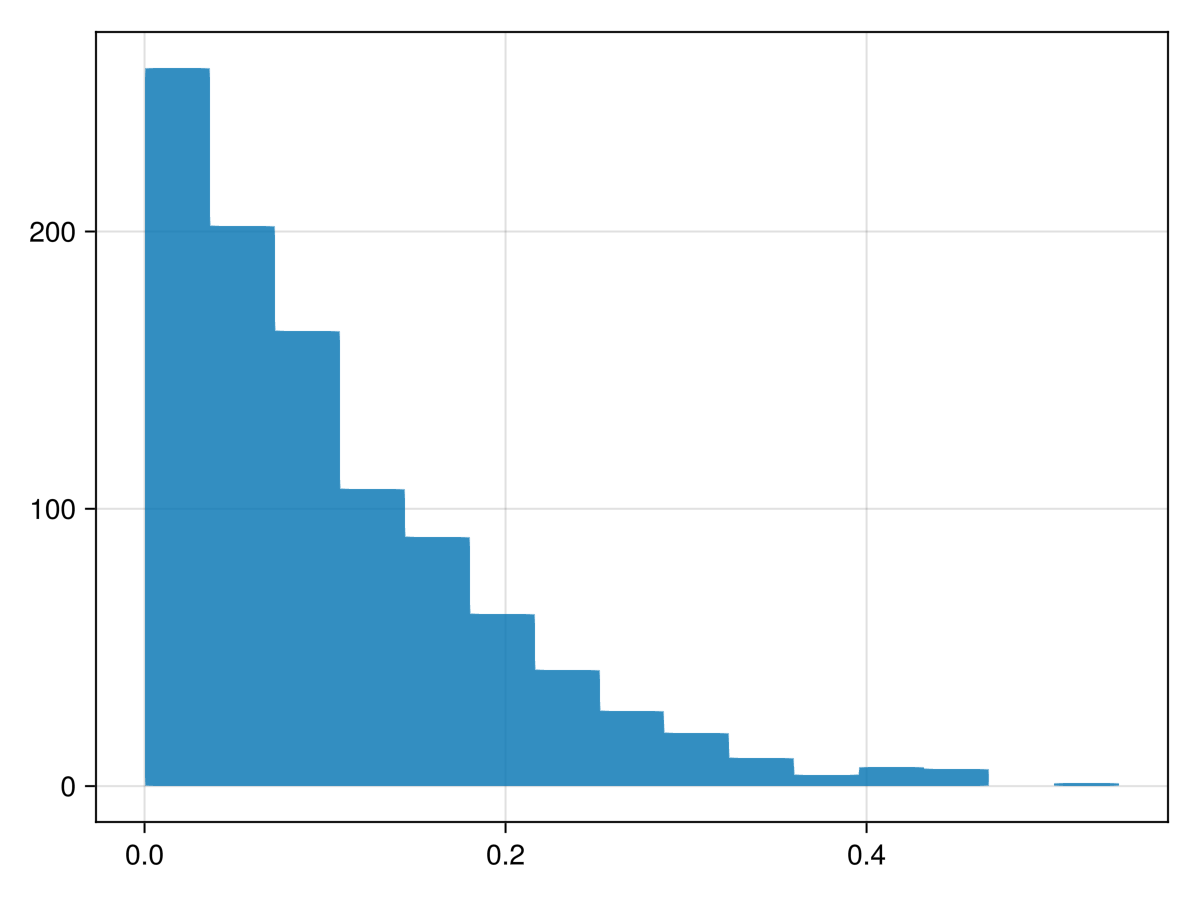

In [76]:
hist(c)